In [79]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np

In [80]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [81]:
%matplotlib inline
swift = SWIFT(root_path=r'data', res=64, n_bands=[1,2,3,4,5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


In [82]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_False.npz'))
grb_names, features = data_loaded['names'], data_loaded['data']
durations = swift.total_durations(grb_names, t=90)

Finding Durations: 100%|██████████████████| 1502/1502 [00:14<00:00, 104.85GRB/s]


In [83]:
features.shape

(1502, 96000)

In [84]:
features

array([[0.02207145, 0.02282284, 0.02364542, ..., 0.        , 0.        ,
        0.        ],
       [0.01934268, 0.01978875, 0.02025528, ..., 0.        , 0.        ,
        0.        ],
       [0.05054836, 0.05457711, 0.05522887, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00044017, 0.00048221, 0.00051567, ..., 0.        , 0.        ,
        0.        ],
       [0.08797799, 0.09079959, 0.10159098, ..., 0.        , 0.        ,
        0.        ],
       [0.01593894, 0.01604221, 0.01602993, ..., 0.        , 0.        ,
        0.        ]])

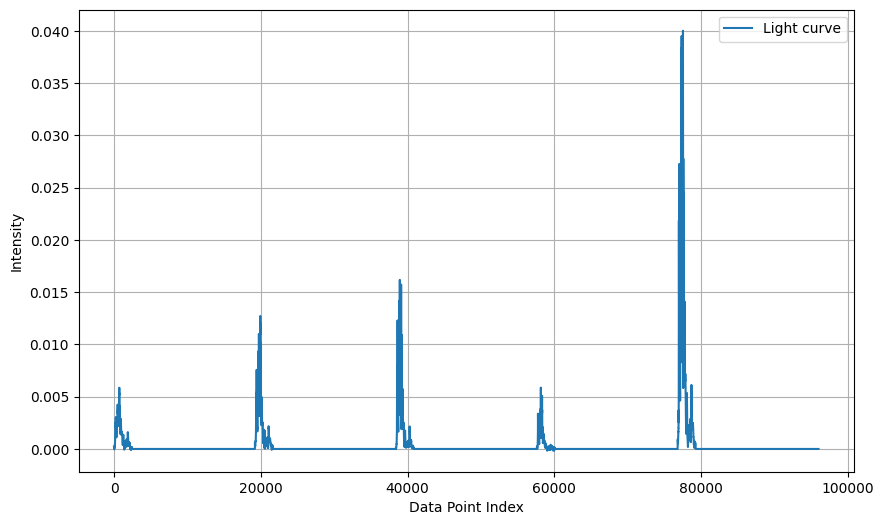

In [123]:
x = np.linspace(0, features.shape[1], features.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(x, features[3], label='Light curve')  # Converting tensor to numpy array for plotting
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)

In [86]:
bandwidth = int(features.shape[1]/5)

# find how much of the 5th band is zeros
fifth_band = features[:,4*bandwidth:]
fifth_band

array([[0.12628723, 0.12995042, 0.13339197, ..., 0.        , 0.        ,
        0.        ],
       [0.06564761, 0.06779037, 0.06973962, ..., 0.        , 0.        ,
        0.        ],
       [0.19272945, 0.21456671, 0.21170661, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00471877, 0.0048695 , 0.00502066, ..., 0.        , 0.        ,
        0.        ],
       [0.34240494, 0.35000814, 0.35460609, ..., 0.        , 0.        ,
        0.        ],
       [0.0190079 , 0.02103801, 0.02228608, ..., 0.        , 0.        ,
        0.        ]])

In [87]:
fifth_band.shape

(1502, 19200)

In [88]:
def find_critical_index(row):
    # Reverse the row and find the first non-zero element
    reversed_row = row[::-1]
    for index, value in enumerate(reversed_row):
        if value != 0:
            # Subtract the index from the length of the row to get the actual index
            return len(row) - index - 1
    return -1  # Return -1 or any specific marker if the row is all zeros

# Apply the function to each row
critical_indices = np.array([find_critical_index(row) for row in fifth_band])

print("Critical indices:", critical_indices)

Critical indices: [109 186 109 ... 840  42 284]


In [89]:
# Exploring the array
print("Shape of the array:", critical_indices.shape)
print("Data type of the array:", critical_indices.dtype)
print("Number of dimensions:", critical_indices.ndim)
print("Total number of elements:", critical_indices.size)

# Describing the critical_indices
print("Mean of the array:", np.mean(critical_indices))
print("Standard deviation:", np.std(critical_indices))
print("Minimum value:", np.min(critical_indices))
print("Maximum value:", np.max(critical_indices))
print("25th percentile:", np.percentile(critical_indices, 25))
print("Median:", np.median(critical_indices))
print("75th percentile:", np.percentile(critical_indices, 75))
print("90th percentile:", np.percentile(critical_indices, 90))
print("95th percentile:", np.percentile(critical_indices, 95))
print("99th percentile:", np.percentile(critical_indices, 99))

Shape of the array: (1502,)
Data type of the array: int64
Number of dimensions: 1
Total number of elements: 1502
Mean of the array: 1555.3868175765647
Standard deviation: 2171.083806223932
Minimum value: 2
Maximum value: 19117
25th percentile: 209.25
Median: 784.0
75th percentile: 2010.0
90th percentile: 3875.8
95th percentile: 5515.700000000001
99th percentile: 11483.630000000003


In [124]:
# to save compute, cutoff using the 95th percentile
old_lightcurve_length = int(features.shape[1]/5)
new_lightcurve_length = 5000
bands = np.array([None]*5)
for i in range(5):
    bands[i] = features[:,i*old_lightcurve_length:i*old_lightcurve_length + new_lightcurve_length]

In [125]:
new_features = np.hstack(bands)

In [126]:
new_features.shape

(1502, 25000)

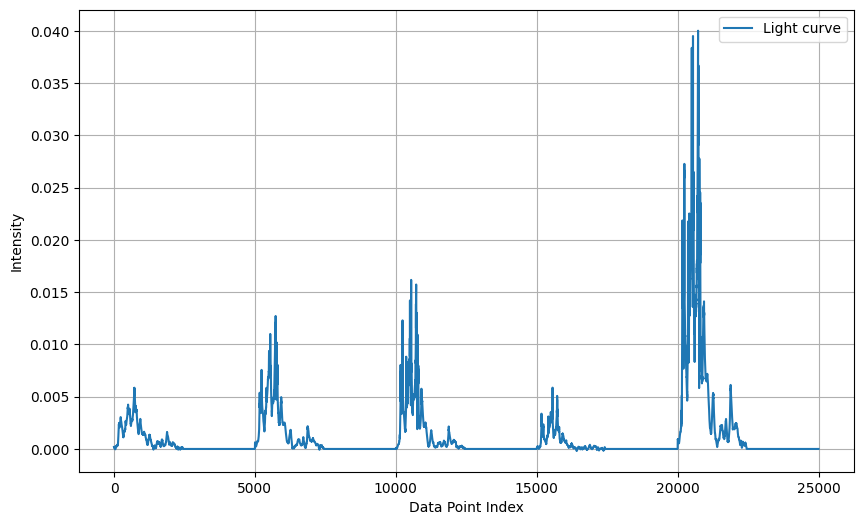

In [127]:
x = np.linspace(0, new_features.shape[1], new_features.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(x, new_features[3], label='Light curve')  # Converting tensor to numpy array for plotting
plt.xlabel('Data Point Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)

In [128]:
features = new_features

In [148]:
# furthermore, use total flux to save compute time
features = features[:,4*new_lightcurve_length:]

In [149]:
print(np.mean(features,axis=1))
print(np.std(features,axis=1))

[0.00314395 0.00313444 0.0031467  ... 0.00312557 0.00318634 0.00313038]
[0.02169436 0.01684791 0.02471875 ... 0.00975463 0.03458396 0.01356636]


In [150]:
# Normalize the features here
normalized_features = (features - np.mean(features, axis=1, keepdims=1))/np.std(features,axis=1,keepdims=1)
print(normalized_features.shape)
print(np.mean(normalized_features,axis=1))
print(np.std(normalized_features,axis=1))

(1502, 5000)
[ 1.13686838e-17 -4.54747351e-17  0.00000000e+00 ... -4.54747351e-17
  1.13686838e-17  0.00000000e+00]
[1. 1. 1. ... 1. 1. 1.]


In [151]:
_normalized_features = normalized_features # copy this so rerunning next cell doesn't throw error
_labels = np.zeros(shape=(normalized_features.shape[0],1))

In [152]:
normalized_features = torch.from_numpy(_normalized_features).to(torch.float32)
labels = torch.from_numpy(_labels).to(torch.float32)

In [153]:
# Check for rows with NaN values and remove them from both features and labels
mask = ~torch.isnan(normalized_features).any(dim=1) & ~torch.isnan(labels).any(dim=1)
clean_features = normalized_features[mask]
clean_labels = labels[mask]
torch.sum(~mask)

tensor(0)

In [201]:

# Split the cleaned data into training and testing sets
X_train, X_test, class_train, class_test = train_test_split(clean_features, clean_labels, test_size=0.2, random_state=205)


training_dataset = TensorDataset(X_train, class_train)
test_dataset = TensorDataset(X_test, class_test)

BATCHSIZE = 128
BATCHSIZE_TEST = 256

train_dataloader = DataLoader(training_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)

In [243]:
INPUT_SIZE      = features.shape[1]
LATENT_SIZE     = 3
HIDDEN_SIZE_1     = 500
HIDDEN_SIZE_2     = 50

In [244]:
# Note that this code is largely from https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Sessions/Session14
# First, we will inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class Encoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # here we are initializing the linear layers. This registeres the layer parameters (W,b) as parameters of the Module
        self.fc1 = nn.Linear(INPUT_SIZE,HIDDEN_SIZE_1)
        self.fc2 = nn.Linear(HIDDEN_SIZE_1,HIDDEN_SIZE_2)
        self.fc3 = nn.Linear(HIDDEN_SIZE_2,LATENT_SIZE)

        # We will initialize weights following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc3.bias, mean=0, std=0.01)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        # print(x.dtype)
        # print(self.fc1.weight.dtype)
        # print(self.fc1.bias.dtype) # for debugging dtype mismatch
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        x      = torch.nn.LeakyReLU()(self.fc2(x))
        z      = self.fc3(x)
        return z

class Decoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Using the encoder, how will you initialize two layers?
        self.fc1 = nn.Linear(LATENT_SIZE,HIDDEN_SIZE_2)
        self.fc2 = nn.Linear(HIDDEN_SIZE_2,HIDDEN_SIZE_1)
        self.fc3 = nn.Linear(HIDDEN_SIZE_1,INPUT_SIZE)

        # Using the endoer, how will you initialize the weights and biases?
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc3.bias, mean=0, std=0.01)

    def forward(self, z):
        # Using the encoder, how will you define the forward pass?
        # I recommend the same activation function!
        z      = torch.nn.LeakyReLU()(self.fc1(z))
        z      = torch.nn.LeakyReLU()(self.fc2(z))
        x      = self.fc3(z)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [245]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

In [246]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction of the model
        pred = model(X)
        # Compute the loss function
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # here we keep track of the loss
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses

# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg test loss: {test_loss:>8f} \n")

    return test_loss

In [247]:
from tqdm import tqdm

EPOCHS = 200
LEARNING_RATE = 1e-3


# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)


train_loss = []
test_loss  = []
for t in tqdm(range(EPOCHS)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch 1
-------------------------------
train loss: 1.000286  [    0/ 1201]


  0%|▏                                          | 1/200 [00:01<03:45,  1.13s/it]

 Avg test loss: 0.940576 

Epoch 2
-------------------------------
train loss: 0.938392  [    0/ 1201]


  1%|▍                                          | 2/200 [00:02<03:34,  1.08s/it]

 Avg test loss: 0.752984 

Epoch 3
-------------------------------
train loss: 0.775575  [    0/ 1201]


  2%|▋                                          | 3/200 [00:03<03:46,  1.15s/it]

 Avg test loss: 0.652771 

Epoch 4
-------------------------------
train loss: 0.681514  [    0/ 1201]


  2%|▊                                          | 4/200 [00:04<03:45,  1.15s/it]

 Avg test loss: 0.639460 

Epoch 5
-------------------------------
train loss: 0.621242  [    0/ 1201]


  2%|█                                          | 5/200 [00:06<04:19,  1.33s/it]

 Avg test loss: 0.576023 

Epoch 6
-------------------------------
train loss: 0.627005  [    0/ 1201]


  3%|█▎                                         | 6/200 [00:07<04:15,  1.32s/it]

 Avg test loss: 0.566854 

Epoch 7
-------------------------------
train loss: 0.582586  [    0/ 1201]


  4%|█▌                                         | 7/200 [00:08<03:52,  1.20s/it]

 Avg test loss: 0.589371 

Epoch 8
-------------------------------
train loss: 0.618817  [    0/ 1201]


  4%|█▋                                         | 8/200 [00:09<03:41,  1.15s/it]

 Avg test loss: 0.554379 

Epoch 9
-------------------------------
train loss: 0.573821  [    0/ 1201]


  4%|█▉                                         | 9/200 [00:11<04:13,  1.33s/it]

 Avg test loss: 0.571959 

Epoch 10
-------------------------------
train loss: 0.569778  [    0/ 1201]


  5%|██                                        | 10/200 [00:15<06:37,  2.09s/it]

 Avg test loss: 0.553809 

Epoch 11
-------------------------------
train loss: 0.613671  [    0/ 1201]


  6%|██▎                                       | 11/200 [00:19<08:28,  2.69s/it]

 Avg test loss: 0.528521 

Epoch 12
-------------------------------
train loss: 0.599710  [    0/ 1201]


  6%|██▌                                       | 12/200 [00:20<07:23,  2.36s/it]

 Avg test loss: 0.538560 

Epoch 13
-------------------------------
train loss: 0.580290  [    0/ 1201]


  6%|██▋                                       | 13/200 [00:21<05:56,  1.90s/it]

 Avg test loss: 0.524657 

Epoch 14
-------------------------------
train loss: 0.589218  [    0/ 1201]


  7%|██▉                                       | 14/200 [00:23<05:41,  1.84s/it]

 Avg test loss: 0.505436 

Epoch 15
-------------------------------
train loss: 0.545934  [    0/ 1201]


  8%|███▏                                      | 15/200 [00:24<05:22,  1.75s/it]

 Avg test loss: 0.474894 

Epoch 16
-------------------------------
train loss: 0.498928  [    0/ 1201]


  8%|███▎                                      | 16/200 [00:25<04:36,  1.50s/it]

 Avg test loss: 0.447713 

Epoch 17
-------------------------------
train loss: 0.423589  [    0/ 1201]


  8%|███▌                                      | 17/200 [00:26<04:16,  1.40s/it]

 Avg test loss: 0.454237 

Epoch 18
-------------------------------
train loss: 0.463752  [    0/ 1201]


  9%|███▊                                      | 18/200 [00:27<03:57,  1.31s/it]

 Avg test loss: 0.384395 

Epoch 19
-------------------------------
train loss: 0.406213  [    0/ 1201]


 10%|███▉                                      | 19/200 [00:28<03:42,  1.23s/it]

 Avg test loss: 0.373787 

Epoch 20
-------------------------------
train loss: 0.426859  [    0/ 1201]


 10%|████▏                                     | 20/200 [00:29<03:28,  1.16s/it]

 Avg test loss: 0.390549 

Epoch 21
-------------------------------
train loss: 0.374676  [    0/ 1201]


 10%|████▍                                     | 21/200 [00:31<03:20,  1.12s/it]

 Avg test loss: 0.367258 

Epoch 22
-------------------------------
train loss: 0.372188  [    0/ 1201]


 11%|████▌                                     | 22/200 [00:31<03:08,  1.06s/it]

 Avg test loss: 0.369360 

Epoch 23
-------------------------------
train loss: 0.367555  [    0/ 1201]


 12%|████▊                                     | 23/200 [00:32<03:07,  1.06s/it]

 Avg test loss: 0.365651 

Epoch 24
-------------------------------
train loss: 0.355913  [    0/ 1201]


 12%|█████                                     | 24/200 [00:34<03:13,  1.10s/it]

 Avg test loss: 0.331858 

Epoch 25
-------------------------------
train loss: 0.338103  [    0/ 1201]


 12%|█████▎                                    | 25/200 [00:35<03:18,  1.13s/it]

 Avg test loss: 0.337849 

Epoch 26
-------------------------------
train loss: 0.337851  [    0/ 1201]


 13%|█████▍                                    | 26/200 [00:36<03:12,  1.11s/it]

 Avg test loss: 0.349280 

Epoch 27
-------------------------------
train loss: 0.348176  [    0/ 1201]


 14%|█████▋                                    | 27/200 [00:37<03:10,  1.10s/it]

 Avg test loss: 0.318847 

Epoch 28
-------------------------------
train loss: 0.345650  [    0/ 1201]


 14%|█████▉                                    | 28/200 [00:38<03:13,  1.12s/it]

 Avg test loss: 0.320775 

Epoch 29
-------------------------------
train loss: 0.343988  [    0/ 1201]


 14%|██████                                    | 29/200 [00:39<03:04,  1.08s/it]

 Avg test loss: 0.311068 

Epoch 30
-------------------------------
train loss: 0.300944  [    0/ 1201]


 15%|██████▎                                   | 30/200 [00:40<03:08,  1.11s/it]

 Avg test loss: 0.309398 

Epoch 31
-------------------------------
train loss: 0.288412  [    0/ 1201]


 16%|██████▌                                   | 31/200 [00:42<03:21,  1.19s/it]

 Avg test loss: 0.298631 

Epoch 32
-------------------------------
train loss: 0.272781  [    0/ 1201]


 16%|██████▋                                   | 32/200 [00:43<03:37,  1.30s/it]

 Avg test loss: 0.289767 

Epoch 33
-------------------------------
train loss: 0.310744  [    0/ 1201]


 16%|██████▉                                   | 33/200 [00:46<05:06,  1.83s/it]

 Avg test loss: 0.305774 

Epoch 34
-------------------------------
train loss: 0.310596  [    0/ 1201]


 17%|███████▏                                  | 34/200 [00:49<05:46,  2.09s/it]

 Avg test loss: 0.280592 

Epoch 35
-------------------------------
train loss: 0.285727  [    0/ 1201]


 18%|███████▎                                  | 35/200 [00:51<05:30,  2.00s/it]

 Avg test loss: 0.284104 

Epoch 36
-------------------------------
train loss: 0.266213  [    0/ 1201]


 18%|███████▌                                  | 36/200 [00:55<06:51,  2.51s/it]

 Avg test loss: 0.288565 

Epoch 37
-------------------------------
train loss: 0.309730  [    0/ 1201]


 18%|███████▊                                  | 37/200 [00:59<08:01,  2.95s/it]

 Avg test loss: 0.284304 

Epoch 38
-------------------------------
train loss: 0.286431  [    0/ 1201]


 19%|███████▉                                  | 38/200 [01:03<08:57,  3.32s/it]

 Avg test loss: 0.275903 

Epoch 39
-------------------------------
train loss: 0.287459  [    0/ 1201]


 20%|████████▏                                 | 39/200 [01:07<09:23,  3.50s/it]

 Avg test loss: 0.263978 

Epoch 40
-------------------------------
train loss: 0.270053  [    0/ 1201]


 20%|████████▍                                 | 40/200 [01:10<09:20,  3.51s/it]

 Avg test loss: 0.265029 

Epoch 41
-------------------------------
train loss: 0.259122  [    0/ 1201]


 20%|████████▌                                 | 41/200 [01:13<08:38,  3.26s/it]

 Avg test loss: 0.274571 

Epoch 42
-------------------------------
train loss: 0.258044  [    0/ 1201]


 21%|████████▊                                 | 42/200 [01:15<07:59,  3.04s/it]

 Avg test loss: 0.265571 

Epoch 43
-------------------------------
train loss: 0.257261  [    0/ 1201]


 22%|█████████                                 | 43/200 [01:18<07:21,  2.81s/it]

 Avg test loss: 0.263651 

Epoch 44
-------------------------------
train loss: 0.255539  [    0/ 1201]


 22%|█████████▏                                | 44/200 [01:20<07:15,  2.79s/it]

 Avg test loss: 0.260322 

Epoch 45
-------------------------------
train loss: 0.269074  [    0/ 1201]


 22%|█████████▍                                | 45/200 [01:23<07:13,  2.80s/it]

 Avg test loss: 0.257182 

Epoch 46
-------------------------------
train loss: 0.224766  [    0/ 1201]


 23%|█████████▋                                | 46/200 [01:25<06:34,  2.56s/it]

 Avg test loss: 0.254769 

Epoch 47
-------------------------------
train loss: 0.246387  [    0/ 1201]


 24%|█████████▊                                | 47/200 [01:27<05:53,  2.31s/it]

 Avg test loss: 0.252499 

Epoch 48
-------------------------------
train loss: 0.247956  [    0/ 1201]


 24%|██████████                                | 48/200 [01:29<05:42,  2.26s/it]

 Avg test loss: 0.242669 

Epoch 49
-------------------------------
train loss: 0.248086  [    0/ 1201]


 24%|██████████▎                               | 49/200 [01:32<06:16,  2.49s/it]

 Avg test loss: 0.248360 

Epoch 50
-------------------------------
train loss: 0.261047  [    0/ 1201]


 25%|██████████▌                               | 50/200 [01:34<05:41,  2.28s/it]

 Avg test loss: 0.256132 

Epoch 51
-------------------------------
train loss: 0.255008  [    0/ 1201]


 26%|██████████▋                               | 51/200 [01:36<05:45,  2.32s/it]

 Avg test loss: 0.253700 

Epoch 52
-------------------------------
train loss: 0.244666  [    0/ 1201]


 26%|██████████▉                               | 52/200 [01:38<05:33,  2.25s/it]

 Avg test loss: 0.255269 

Epoch 53
-------------------------------
train loss: 0.281008  [    0/ 1201]


 26%|███████████▏                              | 53/200 [01:41<05:26,  2.22s/it]

 Avg test loss: 0.230460 

Epoch 54
-------------------------------
train loss: 0.232081  [    0/ 1201]


 27%|███████████▎                              | 54/200 [01:42<05:01,  2.07s/it]

 Avg test loss: 0.244759 

Epoch 55
-------------------------------
train loss: 0.244708  [    0/ 1201]


 28%|███████████▌                              | 55/200 [01:44<04:29,  1.86s/it]

 Avg test loss: 0.228275 

Epoch 56
-------------------------------
train loss: 0.201801  [    0/ 1201]


 28%|███████████▊                              | 56/200 [01:45<03:58,  1.66s/it]

 Avg test loss: 0.239572 

Epoch 57
-------------------------------
train loss: 0.216428  [    0/ 1201]


 28%|███████████▉                              | 57/200 [01:46<03:54,  1.64s/it]

 Avg test loss: 0.220587 

Epoch 58
-------------------------------
train loss: 0.253830  [    0/ 1201]


 29%|████████████▏                             | 58/200 [01:48<04:04,  1.72s/it]

 Avg test loss: 0.229630 

Epoch 59
-------------------------------
train loss: 0.226664  [    0/ 1201]


 30%|████████████▍                             | 59/200 [01:49<03:36,  1.54s/it]

 Avg test loss: 0.235720 

Epoch 60
-------------------------------
train loss: 0.220398  [    0/ 1201]


 30%|████████████▌                             | 60/200 [01:50<03:12,  1.37s/it]

 Avg test loss: 0.213417 

Epoch 61
-------------------------------
train loss: 0.246471  [    0/ 1201]


 30%|████████████▊                             | 61/200 [01:51<02:52,  1.24s/it]

 Avg test loss: 0.227949 

Epoch 62
-------------------------------
train loss: 0.219040  [    0/ 1201]


 31%|█████████████                             | 62/200 [01:52<02:44,  1.19s/it]

 Avg test loss: 0.242516 

Epoch 63
-------------------------------
train loss: 0.225931  [    0/ 1201]


 32%|█████████████▏                            | 63/200 [01:54<02:40,  1.17s/it]

 Avg test loss: 0.226058 

Epoch 64
-------------------------------
train loss: 0.220474  [    0/ 1201]


 32%|█████████████▍                            | 64/200 [01:55<02:37,  1.16s/it]

 Avg test loss: 0.241320 

Epoch 65
-------------------------------
train loss: 0.206460  [    0/ 1201]


 32%|█████████████▋                            | 65/200 [01:56<02:34,  1.14s/it]

 Avg test loss: 0.238284 

Epoch 66
-------------------------------
train loss: 0.239684  [    0/ 1201]


 33%|█████████████▊                            | 66/200 [01:57<02:27,  1.10s/it]

 Avg test loss: 0.236592 

Epoch 67
-------------------------------
train loss: 0.243565  [    0/ 1201]


 34%|██████████████                            | 67/200 [01:58<02:26,  1.10s/it]

 Avg test loss: 0.225521 

Epoch 68
-------------------------------
train loss: 0.203080  [    0/ 1201]


 34%|██████████████▎                           | 68/200 [01:59<02:25,  1.11s/it]

 Avg test loss: 0.225293 

Epoch 69
-------------------------------
train loss: 0.240941  [    0/ 1201]


 34%|██████████████▍                           | 69/200 [02:00<02:21,  1.08s/it]

 Avg test loss: 0.225945 

Epoch 70
-------------------------------
train loss: 0.235127  [    0/ 1201]


 35%|██████████████▋                           | 70/200 [02:01<02:11,  1.01s/it]

 Avg test loss: 0.239820 

Epoch 71
-------------------------------
train loss: 0.196867  [    0/ 1201]


 36%|██████████████▉                           | 71/200 [02:02<02:03,  1.04it/s]

 Avg test loss: 0.228890 

Epoch 72
-------------------------------
train loss: 0.192643  [    0/ 1201]


 36%|███████████████                           | 72/200 [02:03<02:04,  1.03it/s]

 Avg test loss: 0.232721 

Epoch 73
-------------------------------
train loss: 0.221420  [    0/ 1201]


 36%|███████████████▎                          | 73/200 [02:04<02:02,  1.04it/s]

 Avg test loss: 0.210229 

Epoch 74
-------------------------------
train loss: 0.191124  [    0/ 1201]


 37%|███████████████▌                          | 74/200 [02:05<02:03,  1.02it/s]

 Avg test loss: 0.216481 

Epoch 75
-------------------------------
train loss: 0.220976  [    0/ 1201]


 38%|███████████████▊                          | 75/200 [02:06<02:05,  1.01s/it]

 Avg test loss: 0.229695 

Epoch 76
-------------------------------
train loss: 0.184185  [    0/ 1201]


 38%|███████████████▉                          | 76/200 [02:07<02:04,  1.01s/it]

 Avg test loss: 0.224395 

Epoch 77
-------------------------------
train loss: 0.219674  [    0/ 1201]


 38%|████████████████▏                         | 77/200 [02:08<01:58,  1.04it/s]

 Avg test loss: 0.245485 

Epoch 78
-------------------------------
train loss: 0.216500  [    0/ 1201]


 39%|████████████████▍                         | 78/200 [02:08<01:52,  1.08it/s]

 Avg test loss: 0.219214 

Epoch 79
-------------------------------
train loss: 0.218357  [    0/ 1201]


 40%|████████████████▌                         | 79/200 [02:10<02:25,  1.20s/it]

 Avg test loss: 0.221399 

Epoch 80
-------------------------------
train loss: 0.197881  [    0/ 1201]


 40%|████████████████▊                         | 80/200 [02:12<02:27,  1.23s/it]

 Avg test loss: 0.239994 

Epoch 81
-------------------------------
train loss: 0.166019  [    0/ 1201]


 40%|█████████████████                         | 81/200 [02:13<02:21,  1.19s/it]

 Avg test loss: 0.204948 

Epoch 82
-------------------------------
train loss: 0.196170  [    0/ 1201]


 41%|█████████████████▏                        | 82/200 [02:14<02:14,  1.14s/it]

 Avg test loss: 0.245800 

Epoch 83
-------------------------------
train loss: 0.216042  [    0/ 1201]


 42%|█████████████████▍                        | 83/200 [02:15<02:02,  1.04s/it]

 Avg test loss: 0.222065 

Epoch 84
-------------------------------
train loss: 0.189103  [    0/ 1201]


 42%|█████████████████▋                        | 84/200 [02:16<01:59,  1.03s/it]

 Avg test loss: 0.234034 

Epoch 85
-------------------------------
train loss: 0.199069  [    0/ 1201]


 42%|█████████████████▊                        | 85/200 [02:17<02:04,  1.08s/it]

 Avg test loss: 0.249146 

Epoch 86
-------------------------------
train loss: 0.173556  [    0/ 1201]


 43%|██████████████████                        | 86/200 [02:18<02:01,  1.07s/it]

 Avg test loss: 0.222308 

Epoch 87
-------------------------------
train loss: 0.210788  [    0/ 1201]


 44%|██████████████████▎                       | 87/200 [02:19<01:59,  1.05s/it]

 Avg test loss: 0.220192 

Epoch 88
-------------------------------
train loss: 0.198618  [    0/ 1201]


 44%|██████████████████▍                       | 88/200 [02:20<01:57,  1.05s/it]

 Avg test loss: 0.238858 

Epoch 89
-------------------------------
train loss: 0.218807  [    0/ 1201]


 44%|██████████████████▋                       | 89/200 [02:21<01:49,  1.02it/s]

 Avg test loss: 0.212752 

Epoch 90
-------------------------------
train loss: 0.224709  [    0/ 1201]


 45%|██████████████████▉                       | 90/200 [02:21<01:43,  1.07it/s]

 Avg test loss: 0.212258 

Epoch 91
-------------------------------
train loss: 0.196160  [    0/ 1201]


 46%|███████████████████                       | 91/200 [02:23<01:59,  1.10s/it]

 Avg test loss: 0.228801 

Epoch 92
-------------------------------
train loss: 0.202920  [    0/ 1201]


 46%|███████████████████▎                      | 92/200 [02:24<01:51,  1.03s/it]

 Avg test loss: 0.216922 

Epoch 93
-------------------------------
train loss: 0.183038  [    0/ 1201]


 46%|███████████████████▌                      | 93/200 [02:25<01:43,  1.03it/s]

 Avg test loss: 0.242677 

Epoch 94
-------------------------------
train loss: 0.191032  [    0/ 1201]


 47%|███████████████████▋                      | 94/200 [02:25<01:38,  1.08it/s]

 Avg test loss: 0.214682 

Epoch 95
-------------------------------
train loss: 0.214013  [    0/ 1201]


 48%|███████████████████▉                      | 95/200 [02:26<01:36,  1.09it/s]

 Avg test loss: 0.221443 

Epoch 96
-------------------------------
train loss: 0.195043  [    0/ 1201]


 48%|████████████████████▏                     | 96/200 [02:27<01:32,  1.12it/s]

 Avg test loss: 0.221622 

Epoch 97
-------------------------------
train loss: 0.195682  [    0/ 1201]


 48%|████████████████████▎                     | 97/200 [02:28<01:35,  1.08it/s]

 Avg test loss: 0.202644 

Epoch 98
-------------------------------
train loss: 0.183259  [    0/ 1201]


 49%|████████████████████▌                     | 98/200 [02:29<01:34,  1.08it/s]

 Avg test loss: 0.206563 

Epoch 99
-------------------------------
train loss: 0.201540  [    0/ 1201]


 50%|████████████████████▊                     | 99/200 [02:30<01:35,  1.06it/s]

 Avg test loss: 0.247047 

Epoch 100
-------------------------------
train loss: 0.175225  [    0/ 1201]


 50%|████████████████████▌                    | 100/200 [02:31<01:33,  1.06it/s]

 Avg test loss: 0.231331 

Epoch 101
-------------------------------
train loss: 0.172047  [    0/ 1201]


 50%|████████████████████▋                    | 101/200 [02:32<01:31,  1.09it/s]

 Avg test loss: 0.201429 

Epoch 102
-------------------------------
train loss: 0.203679  [    0/ 1201]


 51%|████████████████████▉                    | 102/200 [02:33<01:37,  1.01it/s]

 Avg test loss: 0.215705 

Epoch 103
-------------------------------
train loss: 0.202798  [    0/ 1201]


 52%|█████████████████████                    | 103/200 [02:34<01:38,  1.01s/it]

 Avg test loss: 0.221235 

Epoch 104
-------------------------------
train loss: 0.198019  [    0/ 1201]


 52%|█████████████████████▎                   | 104/200 [02:35<01:38,  1.02s/it]

 Avg test loss: 0.211470 

Epoch 105
-------------------------------
train loss: 0.213501  [    0/ 1201]


 52%|█████████████████████▌                   | 105/200 [02:36<01:34,  1.01it/s]

 Avg test loss: 0.222503 

Epoch 106
-------------------------------
train loss: 0.198919  [    0/ 1201]


 53%|█████████████████████▋                   | 106/200 [02:37<01:32,  1.02it/s]

 Avg test loss: 0.226269 

Epoch 107
-------------------------------
train loss: 0.175821  [    0/ 1201]


 54%|█████████████████████▉                   | 107/200 [02:38<01:28,  1.05it/s]

 Avg test loss: 0.213581 

Epoch 108
-------------------------------
train loss: 0.187675  [    0/ 1201]


 54%|██████████████████████▏                  | 108/200 [02:39<01:25,  1.07it/s]

 Avg test loss: 0.210237 

Epoch 109
-------------------------------
train loss: 0.208650  [    0/ 1201]


 55%|██████████████████████▎                  | 109/200 [02:40<01:32,  1.02s/it]

 Avg test loss: 0.210825 

Epoch 110
-------------------------------
train loss: 0.201608  [    0/ 1201]


 55%|██████████████████████▌                  | 110/200 [02:41<01:25,  1.05it/s]

 Avg test loss: 0.206804 

Epoch 111
-------------------------------
train loss: 0.189687  [    0/ 1201]


 56%|██████████████████████▊                  | 111/200 [02:42<01:30,  1.02s/it]

 Avg test loss: 0.207501 

Epoch 112
-------------------------------
train loss: 0.226652  [    0/ 1201]


 56%|██████████████████████▉                  | 112/200 [02:43<01:27,  1.00it/s]

 Avg test loss: 0.216714 

Epoch 113
-------------------------------
train loss: 0.200098  [    0/ 1201]


 56%|███████████████████████▏                 | 113/200 [02:44<01:22,  1.05it/s]

 Avg test loss: 0.214853 

Epoch 114
-------------------------------
train loss: 0.155314  [    0/ 1201]


 57%|███████████████████████▎                 | 114/200 [02:45<01:23,  1.03it/s]

 Avg test loss: 0.249534 

Epoch 115
-------------------------------
train loss: 0.171941  [    0/ 1201]


 57%|███████████████████████▌                 | 115/200 [02:46<01:20,  1.06it/s]

 Avg test loss: 0.218898 

Epoch 116
-------------------------------
train loss: 0.190806  [    0/ 1201]


 58%|███████████████████████▊                 | 116/200 [02:47<01:16,  1.10it/s]

 Avg test loss: 0.235443 

Epoch 117
-------------------------------
train loss: 0.193687  [    0/ 1201]


 58%|███████████████████████▉                 | 117/200 [02:48<01:32,  1.11s/it]

 Avg test loss: 0.222002 

Epoch 118
-------------------------------
train loss: 0.176570  [    0/ 1201]


 59%|████████████████████████▏                | 118/200 [02:49<01:27,  1.07s/it]

 Avg test loss: 0.203147 

Epoch 119
-------------------------------
train loss: 0.202918  [    0/ 1201]


 60%|████████████████████████▍                | 119/200 [02:50<01:27,  1.08s/it]

 Avg test loss: 0.203593 

Epoch 120
-------------------------------
train loss: 0.176434  [    0/ 1201]


 60%|████████████████████████▌                | 120/200 [02:51<01:25,  1.07s/it]

 Avg test loss: 0.208865 

Epoch 121
-------------------------------
train loss: 0.186207  [    0/ 1201]


 60%|████████████████████████▊                | 121/200 [02:52<01:19,  1.00s/it]

 Avg test loss: 0.228204 

Epoch 122
-------------------------------
train loss: 0.176854  [    0/ 1201]


 61%|█████████████████████████                | 122/200 [02:53<01:15,  1.03it/s]

 Avg test loss: 0.227945 

Epoch 123
-------------------------------
train loss: 0.163419  [    0/ 1201]


 62%|█████████████████████████▏               | 123/200 [02:54<01:17,  1.01s/it]

 Avg test loss: 0.228375 

Epoch 124
-------------------------------
train loss: 0.180247  [    0/ 1201]


 62%|█████████████████████████▍               | 124/200 [02:55<01:18,  1.04s/it]

 Avg test loss: 0.236285 

Epoch 125
-------------------------------
train loss: 0.188512  [    0/ 1201]


 62%|█████████████████████████▋               | 125/200 [02:56<01:20,  1.07s/it]

 Avg test loss: 0.218633 

Epoch 126
-------------------------------
train loss: 0.164853  [    0/ 1201]


 63%|█████████████████████████▊               | 126/200 [02:57<01:20,  1.09s/it]

 Avg test loss: 0.207837 

Epoch 127
-------------------------------
train loss: 0.177886  [    0/ 1201]


 64%|██████████████████████████               | 127/200 [02:59<01:30,  1.24s/it]

 Avg test loss: 0.217861 

Epoch 128
-------------------------------
train loss: 0.209551  [    0/ 1201]


 64%|██████████████████████████▏              | 128/200 [03:00<01:25,  1.18s/it]

 Avg test loss: 0.212935 

Epoch 129
-------------------------------
train loss: 0.187819  [    0/ 1201]


 64%|██████████████████████████▍              | 129/200 [03:01<01:21,  1.15s/it]

 Avg test loss: 0.213962 

Epoch 130
-------------------------------
train loss: 0.164402  [    0/ 1201]


 65%|██████████████████████████▋              | 130/200 [03:02<01:16,  1.09s/it]

 Avg test loss: 0.190180 

Epoch 131
-------------------------------
train loss: 0.164166  [    0/ 1201]


 66%|██████████████████████████▊              | 131/200 [03:03<01:13,  1.07s/it]

 Avg test loss: 0.220170 

Epoch 132
-------------------------------
train loss: 0.170009  [    0/ 1201]


 66%|███████████████████████████              | 132/200 [03:04<01:12,  1.06s/it]

 Avg test loss: 0.221081 

Epoch 133
-------------------------------
train loss: 0.163183  [    0/ 1201]


 66%|███████████████████████████▎             | 133/200 [03:05<01:12,  1.08s/it]

 Avg test loss: 0.209968 

Epoch 134
-------------------------------
train loss: 0.179249  [    0/ 1201]


 67%|███████████████████████████▍             | 134/200 [03:06<01:08,  1.04s/it]

 Avg test loss: 0.205727 

Epoch 135
-------------------------------
train loss: 0.169295  [    0/ 1201]


 68%|███████████████████████████▋             | 135/200 [03:08<01:12,  1.11s/it]

 Avg test loss: 0.235341 

Epoch 136
-------------------------------
train loss: 0.158325  [    0/ 1201]


 68%|███████████████████████████▉             | 136/200 [03:08<01:07,  1.05s/it]

 Avg test loss: 0.215407 

Epoch 137
-------------------------------
train loss: 0.163987  [    0/ 1201]


 68%|████████████████████████████             | 137/200 [03:10<01:13,  1.16s/it]

 Avg test loss: 0.215924 

Epoch 138
-------------------------------
train loss: 0.177080  [    0/ 1201]


 69%|████████████████████████████▎            | 138/200 [03:11<01:14,  1.20s/it]

 Avg test loss: 0.189199 

Epoch 139
-------------------------------
train loss: 0.162672  [    0/ 1201]


 70%|████████████████████████████▍            | 139/200 [03:12<01:10,  1.16s/it]

 Avg test loss: 0.213030 

Epoch 140
-------------------------------
train loss: 0.152695  [    0/ 1201]


 70%|████████████████████████████▋            | 140/200 [03:13<01:09,  1.16s/it]

 Avg test loss: 0.225049 

Epoch 141
-------------------------------
train loss: 0.146035  [    0/ 1201]


 70%|████████████████████████████▉            | 141/200 [03:14<01:06,  1.13s/it]

 Avg test loss: 0.215986 

Epoch 142
-------------------------------
train loss: 0.191782  [    0/ 1201]


 71%|█████████████████████████████            | 142/200 [03:16<01:07,  1.16s/it]

 Avg test loss: 0.210487 

Epoch 143
-------------------------------
train loss: 0.151535  [    0/ 1201]


 72%|█████████████████████████████▎           | 143/200 [03:17<01:13,  1.29s/it]

 Avg test loss: 0.211615 

Epoch 144
-------------------------------
train loss: 0.175754  [    0/ 1201]


 72%|█████████████████████████████▌           | 144/200 [03:20<01:36,  1.72s/it]

 Avg test loss: 0.205189 

Epoch 145
-------------------------------
train loss: 0.155287  [    0/ 1201]


 72%|█████████████████████████████▋           | 145/200 [03:22<01:31,  1.66s/it]

 Avg test loss: 0.202780 

Epoch 146
-------------------------------
train loss: 0.184356  [    0/ 1201]


 73%|█████████████████████████████▉           | 146/200 [03:24<01:44,  1.94s/it]

 Avg test loss: 0.213750 

Epoch 147
-------------------------------
train loss: 0.159587  [    0/ 1201]


 74%|██████████████████████████████▏          | 147/200 [03:28<02:10,  2.47s/it]

 Avg test loss: 0.213359 

Epoch 148
-------------------------------
train loss: 0.164775  [    0/ 1201]


 74%|██████████████████████████████▎          | 148/200 [03:32<02:32,  2.93s/it]

 Avg test loss: 0.207757 

Epoch 149
-------------------------------
train loss: 0.181336  [    0/ 1201]


 74%|██████████████████████████████▌          | 149/200 [03:37<03:04,  3.62s/it]

 Avg test loss: 0.198206 

Epoch 150
-------------------------------
train loss: 0.173446  [    0/ 1201]


 75%|██████████████████████████████▊          | 150/200 [03:40<02:54,  3.48s/it]

 Avg test loss: 0.217826 

Epoch 151
-------------------------------
train loss: 0.178705  [    0/ 1201]


 76%|██████████████████████████████▉          | 151/200 [03:42<02:28,  3.03s/it]

 Avg test loss: 0.208233 

Epoch 152
-------------------------------
train loss: 0.158097  [    0/ 1201]


 76%|███████████████████████████████▏         | 152/200 [03:44<02:01,  2.53s/it]

 Avg test loss: 0.229249 

Epoch 153
-------------------------------
train loss: 0.163344  [    0/ 1201]


 76%|███████████████████████████████▎         | 153/200 [03:46<01:51,  2.37s/it]

 Avg test loss: 0.243085 

Epoch 154
-------------------------------
train loss: 0.165905  [    0/ 1201]


 77%|███████████████████████████████▌         | 154/200 [03:47<01:40,  2.19s/it]

 Avg test loss: 0.217841 

Epoch 155
-------------------------------
train loss: 0.169462  [    0/ 1201]


 78%|███████████████████████████████▊         | 155/200 [03:49<01:29,  2.00s/it]

 Avg test loss: 0.205941 

Epoch 156
-------------------------------
train loss: 0.168531  [    0/ 1201]


 78%|███████████████████████████████▉         | 156/200 [03:51<01:28,  2.00s/it]

 Avg test loss: 0.205217 

Epoch 157
-------------------------------
train loss: 0.159761  [    0/ 1201]


 78%|████████████████████████████████▏        | 157/200 [03:52<01:19,  1.85s/it]

 Avg test loss: 0.212597 

Epoch 158
-------------------------------
train loss: 0.153954  [    0/ 1201]


 79%|████████████████████████████████▍        | 158/200 [03:54<01:11,  1.69s/it]

 Avg test loss: 0.203533 

Epoch 159
-------------------------------
train loss: 0.157226  [    0/ 1201]


 80%|████████████████████████████████▌        | 159/200 [03:55<01:04,  1.58s/it]

 Avg test loss: 0.217148 

Epoch 160
-------------------------------
train loss: 0.166269  [    0/ 1201]


 80%|████████████████████████████████▊        | 160/200 [03:57<01:02,  1.56s/it]

 Avg test loss: 0.223006 

Epoch 161
-------------------------------
train loss: 0.159137  [    0/ 1201]


 80%|█████████████████████████████████        | 161/200 [03:58<01:04,  1.65s/it]

 Avg test loss: 0.212039 

Epoch 162
-------------------------------
train loss: 0.173794  [    0/ 1201]


 81%|█████████████████████████████████▏       | 162/200 [04:00<01:02,  1.65s/it]

 Avg test loss: 0.236619 

Epoch 163
-------------------------------
train loss: 0.166386  [    0/ 1201]


 82%|█████████████████████████████████▍       | 163/200 [04:01<00:57,  1.56s/it]

 Avg test loss: 0.223401 

Epoch 164
-------------------------------
train loss: 0.177367  [    0/ 1201]


 82%|█████████████████████████████████▌       | 164/200 [04:03<00:54,  1.51s/it]

 Avg test loss: 0.208023 

Epoch 165
-------------------------------
train loss: 0.150852  [    0/ 1201]


 82%|█████████████████████████████████▊       | 165/200 [04:04<00:52,  1.51s/it]

 Avg test loss: 0.232232 

Epoch 166
-------------------------------
train loss: 0.173936  [    0/ 1201]


 83%|██████████████████████████████████       | 166/200 [04:06<00:52,  1.53s/it]

 Avg test loss: 0.199805 

Epoch 167
-------------------------------
train loss: 0.180175  [    0/ 1201]


 84%|██████████████████████████████████▏      | 167/200 [04:07<00:48,  1.47s/it]

 Avg test loss: 0.214141 

Epoch 168
-------------------------------
train loss: 0.165931  [    0/ 1201]


 84%|██████████████████████████████████▍      | 168/200 [04:09<00:45,  1.44s/it]

 Avg test loss: 0.247244 

Epoch 169
-------------------------------
train loss: 0.172648  [    0/ 1201]


 84%|██████████████████████████████████▋      | 169/200 [04:12<01:00,  1.94s/it]

 Avg test loss: 0.208665 

Epoch 170
-------------------------------
train loss: 0.166082  [    0/ 1201]


 85%|██████████████████████████████████▊      | 170/200 [04:15<01:06,  2.22s/it]

 Avg test loss: 0.199995 

Epoch 171
-------------------------------
train loss: 0.159580  [    0/ 1201]


 86%|███████████████████████████████████      | 171/200 [04:17<01:05,  2.27s/it]

 Avg test loss: 0.207205 

Epoch 172
-------------------------------
train loss: 0.166108  [    0/ 1201]


 86%|███████████████████████████████████▎     | 172/200 [04:19<01:01,  2.20s/it]

 Avg test loss: 0.202898 

Epoch 173
-------------------------------
train loss: 0.148238  [    0/ 1201]


 86%|███████████████████████████████████▍     | 173/200 [04:21<01:01,  2.28s/it]

 Avg test loss: 0.216096 

Epoch 174
-------------------------------
train loss: 0.135511  [    0/ 1201]


 87%|███████████████████████████████████▋     | 174/200 [04:23<00:51,  2.00s/it]

 Avg test loss: 0.211601 

Epoch 175
-------------------------------
train loss: 0.163613  [    0/ 1201]


 88%|███████████████████████████████████▉     | 175/200 [04:24<00:46,  1.85s/it]

 Avg test loss: 0.195242 

Epoch 176
-------------------------------
train loss: 0.149475  [    0/ 1201]


 88%|████████████████████████████████████     | 176/200 [04:26<00:42,  1.78s/it]

 Avg test loss: 0.224270 

Epoch 177
-------------------------------
train loss: 0.176747  [    0/ 1201]


 88%|████████████████████████████████████▎    | 177/200 [04:28<00:39,  1.73s/it]

 Avg test loss: 0.226365 

Epoch 178
-------------------------------
train loss: 0.168965  [    0/ 1201]


 89%|████████████████████████████████████▍    | 178/200 [04:29<00:38,  1.75s/it]

 Avg test loss: 0.222599 

Epoch 179
-------------------------------
train loss: 0.156086  [    0/ 1201]


 90%|████████████████████████████████████▋    | 179/200 [04:32<00:41,  2.00s/it]

 Avg test loss: 0.235312 

Epoch 180
-------------------------------
train loss: 0.169195  [    0/ 1201]


 90%|████████████████████████████████████▉    | 180/200 [04:34<00:39,  1.98s/it]

 Avg test loss: 0.219774 

Epoch 181
-------------------------------
train loss: 0.146076  [    0/ 1201]


 90%|█████████████████████████████████████    | 181/200 [04:35<00:35,  1.86s/it]

 Avg test loss: 0.194724 

Epoch 182
-------------------------------
train loss: 0.165582  [    0/ 1201]


 91%|█████████████████████████████████████▎   | 182/200 [04:37<00:31,  1.73s/it]

 Avg test loss: 0.214861 

Epoch 183
-------------------------------
train loss: 0.138473  [    0/ 1201]


 92%|█████████████████████████████████████▌   | 183/200 [04:38<00:27,  1.63s/it]

 Avg test loss: 0.234158 

Epoch 184
-------------------------------
train loss: 0.177315  [    0/ 1201]


 92%|█████████████████████████████████████▋   | 184/200 [04:40<00:26,  1.64s/it]

 Avg test loss: 0.202261 

Epoch 185
-------------------------------
train loss: 0.166124  [    0/ 1201]


 92%|█████████████████████████████████████▉   | 185/200 [04:41<00:24,  1.61s/it]

 Avg test loss: 0.211856 

Epoch 186
-------------------------------
train loss: 0.166885  [    0/ 1201]


 93%|██████████████████████████████████████▏  | 186/200 [04:43<00:23,  1.65s/it]

 Avg test loss: 0.246930 

Epoch 187
-------------------------------
train loss: 0.183827  [    0/ 1201]


 94%|██████████████████████████████████████▎  | 187/200 [04:45<00:21,  1.64s/it]

 Avg test loss: 0.209763 

Epoch 188
-------------------------------
train loss: 0.173211  [    0/ 1201]


 94%|██████████████████████████████████████▌  | 188/200 [04:46<00:19,  1.59s/it]

 Avg test loss: 0.209488 

Epoch 189
-------------------------------
train loss: 0.168267  [    0/ 1201]


 94%|██████████████████████████████████████▋  | 189/200 [04:48<00:17,  1.55s/it]

 Avg test loss: 0.216943 

Epoch 190
-------------------------------
train loss: 0.147855  [    0/ 1201]


 95%|██████████████████████████████████████▉  | 190/200 [04:50<00:17,  1.73s/it]

 Avg test loss: 0.188806 

Epoch 191
-------------------------------
train loss: 0.150598  [    0/ 1201]


 96%|███████████████████████████████████████▏ | 191/200 [04:52<00:17,  1.90s/it]

 Avg test loss: 0.216430 

Epoch 192
-------------------------------
train loss: 0.152245  [    0/ 1201]


 96%|███████████████████████████████████████▎ | 192/200 [04:54<00:14,  1.77s/it]

 Avg test loss: 0.222552 

Epoch 193
-------------------------------
train loss: 0.169310  [    0/ 1201]


 96%|███████████████████████████████████████▌ | 193/200 [04:55<00:12,  1.74s/it]

 Avg test loss: 0.211066 

Epoch 194
-------------------------------
train loss: 0.152522  [    0/ 1201]


 97%|███████████████████████████████████████▊ | 194/200 [04:58<00:11,  1.91s/it]

 Avg test loss: 0.229048 

Epoch 195
-------------------------------
train loss: 0.150972  [    0/ 1201]


 98%|███████████████████████████████████████▉ | 195/200 [05:00<00:09,  1.92s/it]

 Avg test loss: 0.223311 

Epoch 196
-------------------------------
train loss: 0.168471  [    0/ 1201]


 98%|████████████████████████████████████████▏| 196/200 [05:01<00:07,  1.87s/it]

 Avg test loss: 0.206496 

Epoch 197
-------------------------------
train loss: 0.154017  [    0/ 1201]


 98%|████████████████████████████████████████▍| 197/200 [05:03<00:05,  1.76s/it]

 Avg test loss: 0.208562 

Epoch 198
-------------------------------
train loss: 0.170673  [    0/ 1201]


 99%|████████████████████████████████████████▌| 198/200 [05:04<00:03,  1.73s/it]

 Avg test loss: 0.237084 

Epoch 199
-------------------------------
train loss: 0.152889  [    0/ 1201]


100%|████████████████████████████████████████▊| 199/200 [05:06<00:01,  1.61s/it]

 Avg test loss: 0.219163 

Epoch 200
-------------------------------
train loss: 0.145043  [    0/ 1201]


100%|█████████████████████████████████████████| 200/200 [05:07<00:00,  1.54s/it]

 Avg test loss: 0.203202 

Done!


In [248]:
plot_train_loss = [x[-1] for x in train_loss]

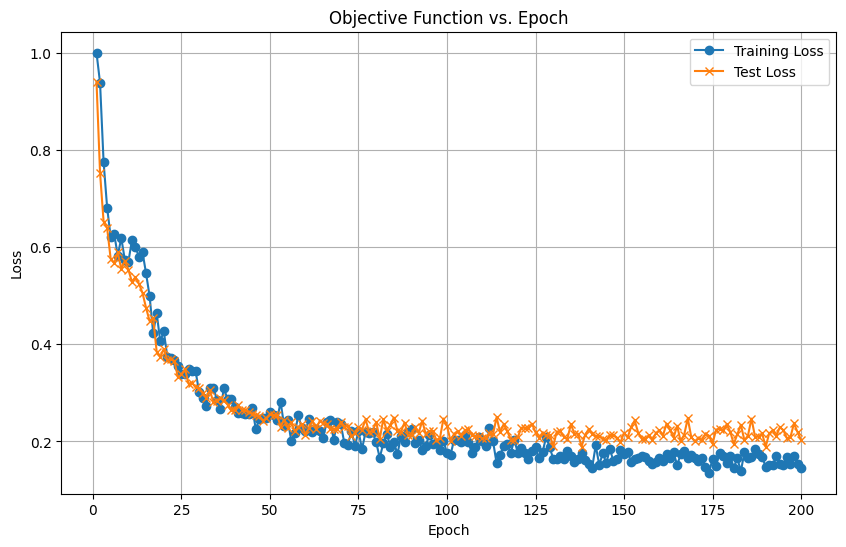

In [249]:
epochs = range(1, len(train_loss) + 1)  # Epochs are 1-based indexing

plt.figure(figsize=(10, 6))
plt.plot(epochs, plot_train_loss, label='Training Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='x')
plt.title('Objective Function vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [237]:
os.getcwd()

'/Users/jeqcho/astro-205/grb'

In [250]:
nr = True
dft = False

fname = "Autoencoder_"
if nr:
    fname += "Noise_Reduced_"
fname += f"{swift.res}res_"
fname += f'{"".join(str(b) for b in swift.n_bands)}bands_'
if dft:
    fname += f'DFT_'
# notes
fname += f'final-3-latent'


torch.save(AE.state_dict(), f'{fname}state_dict.pth')
# torch.save(AE, f'{fname}.pth')
print(f"Model saved to  f'{fname}state_dict.pth")

Model saved to  f'Autoencoder_Noise_Reduced_64res_12345bands_final-3-latentstate_dict.pth


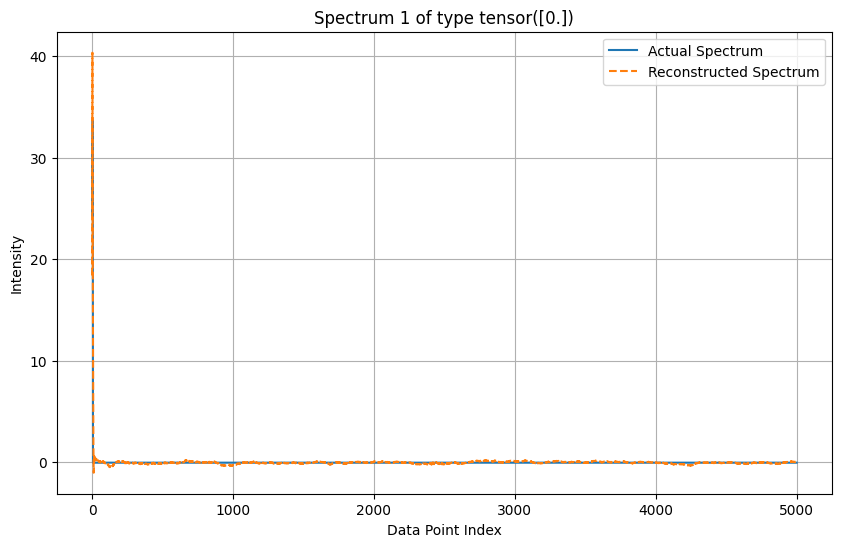

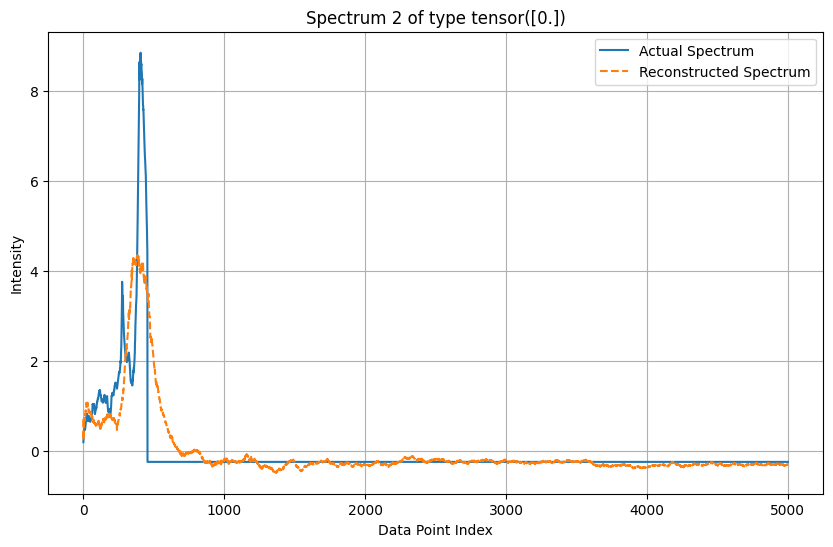

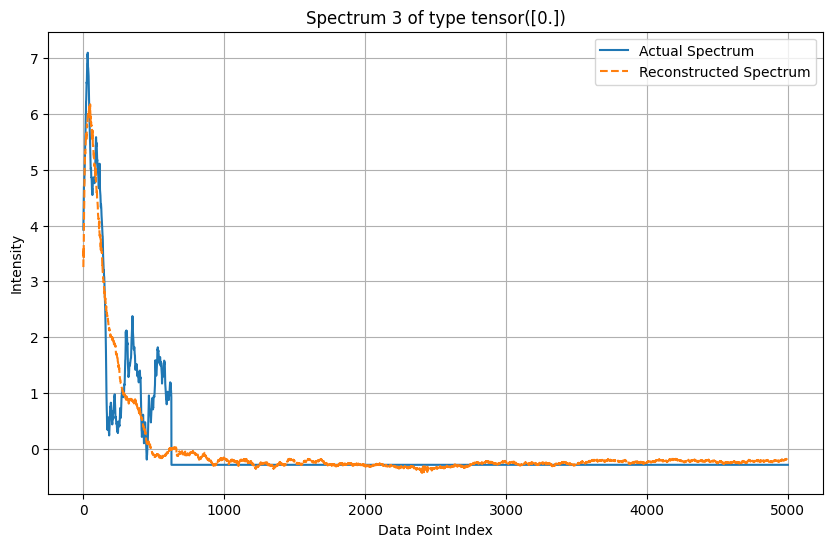

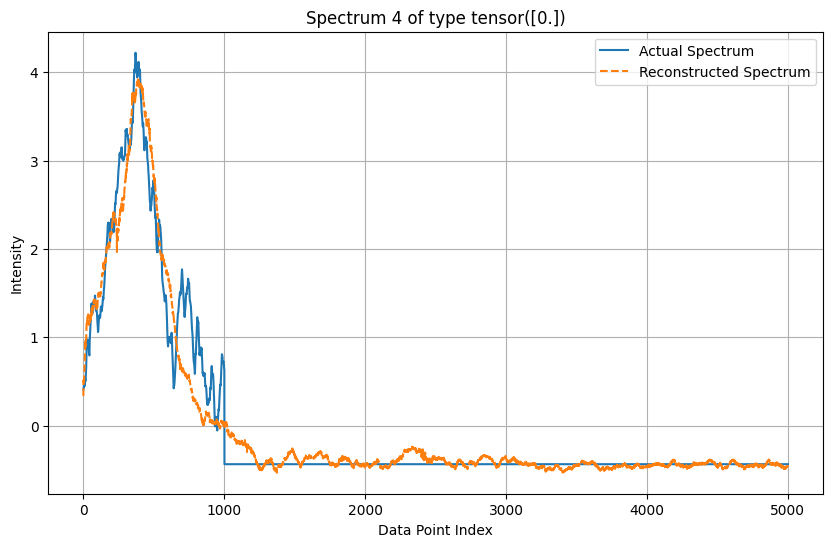

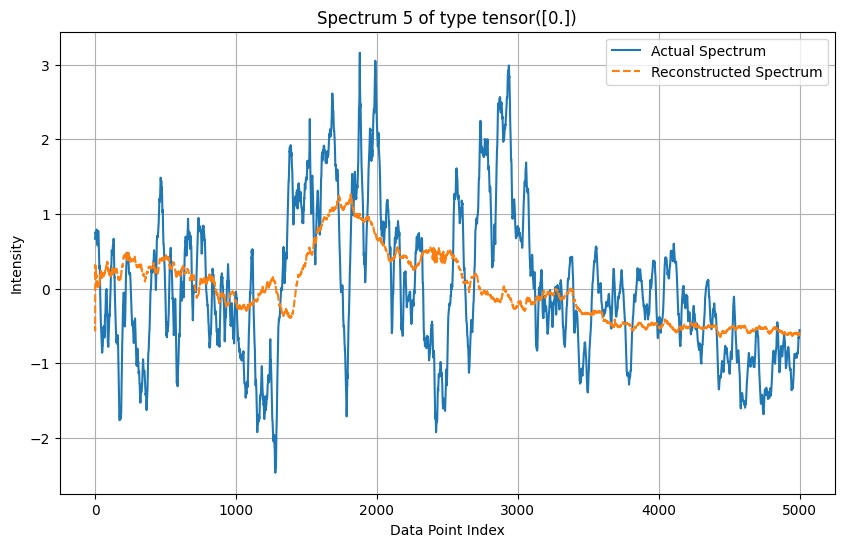

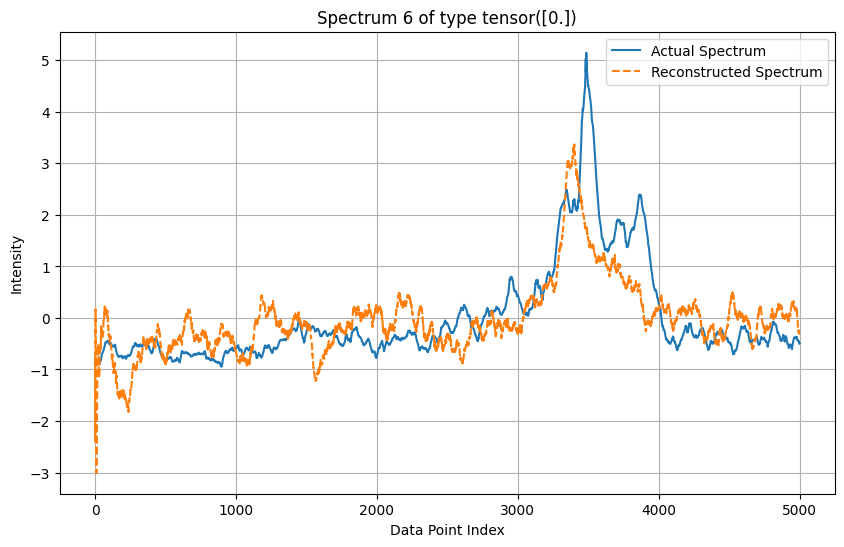

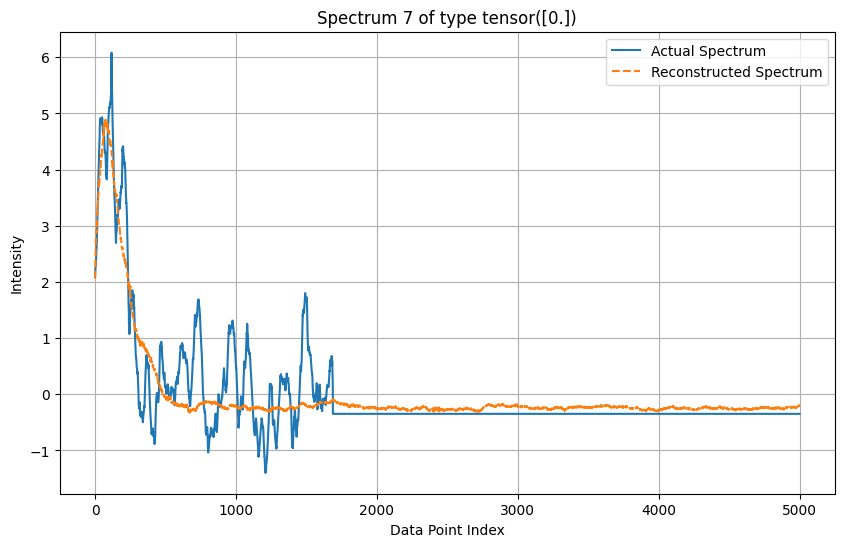

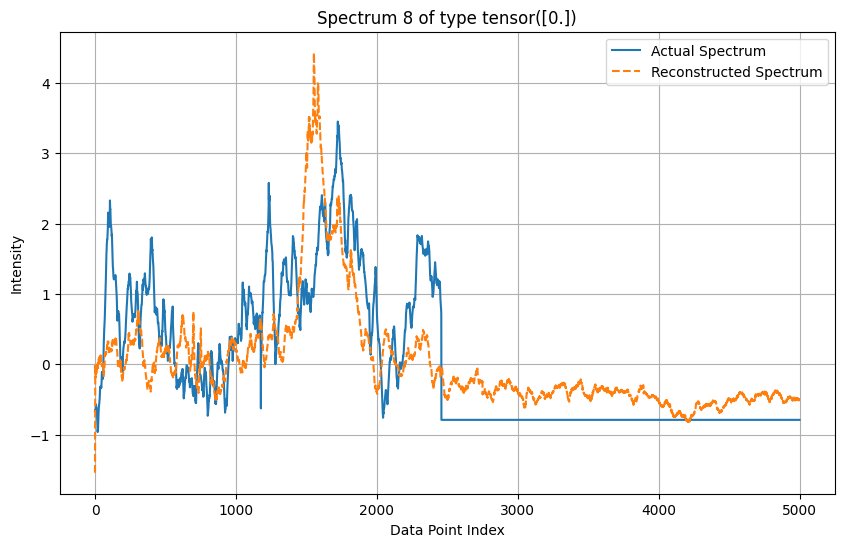

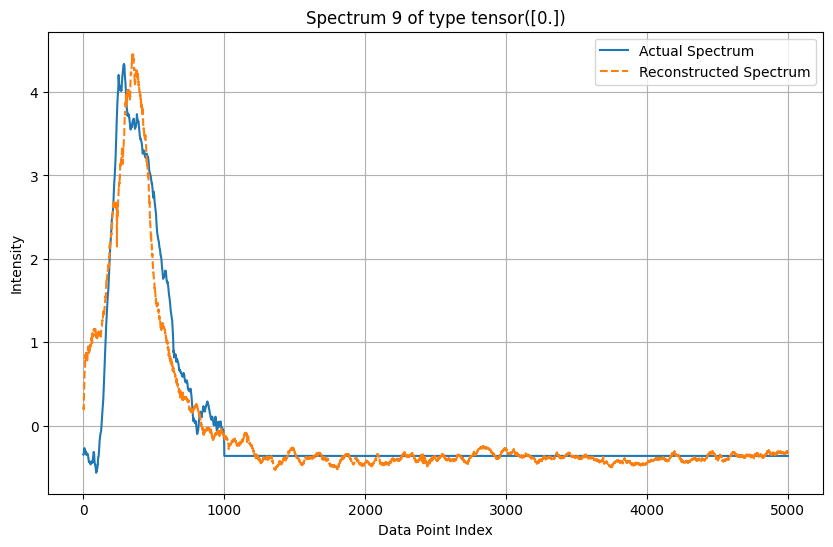

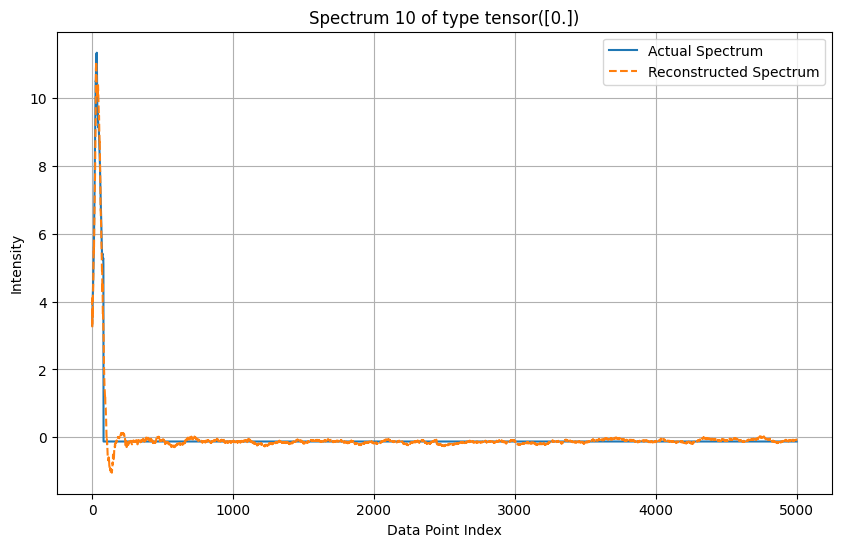

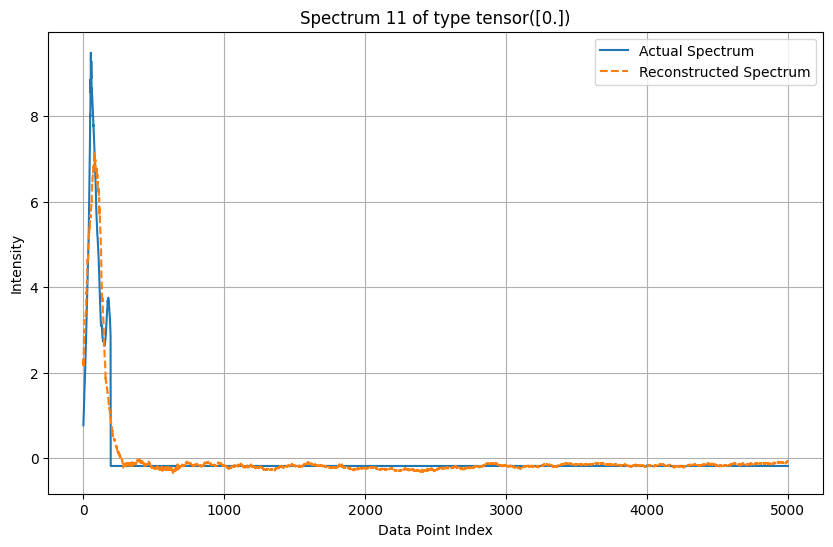

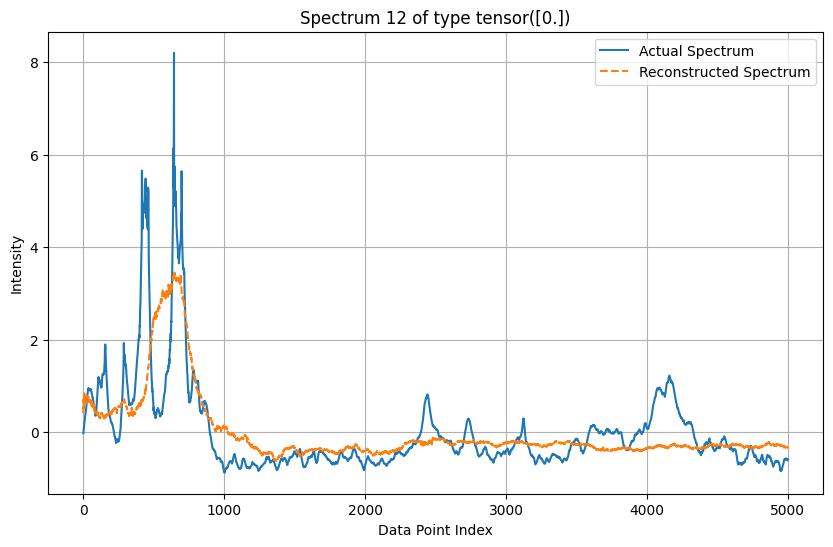

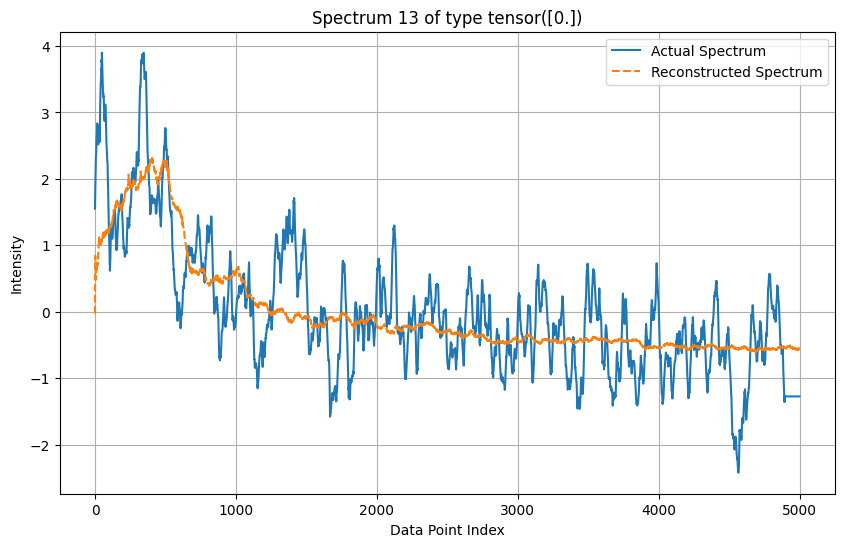

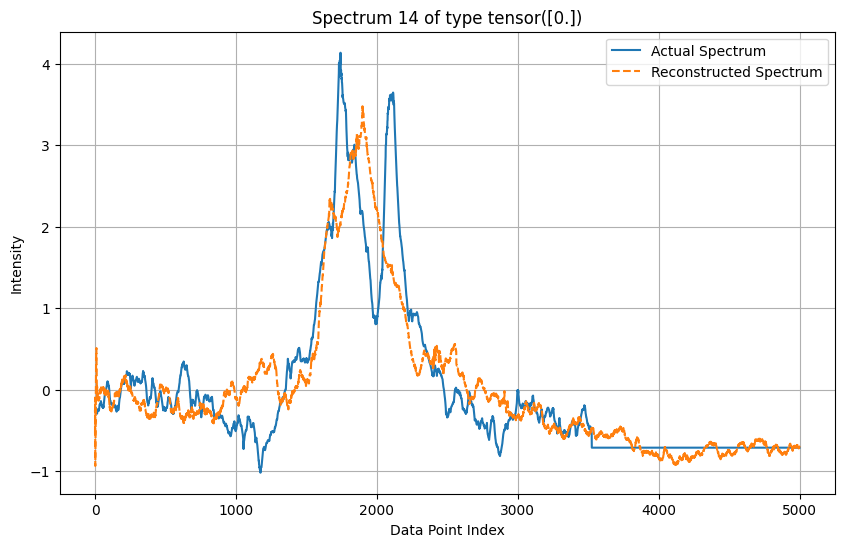

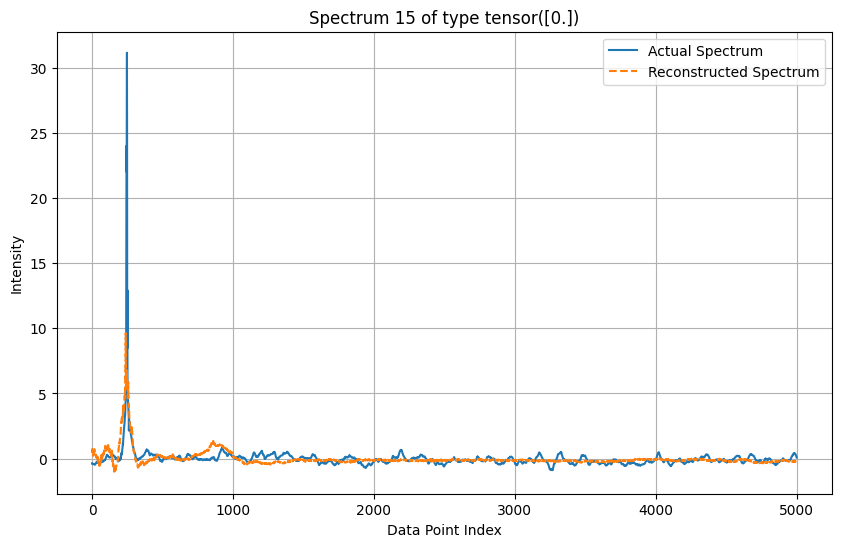

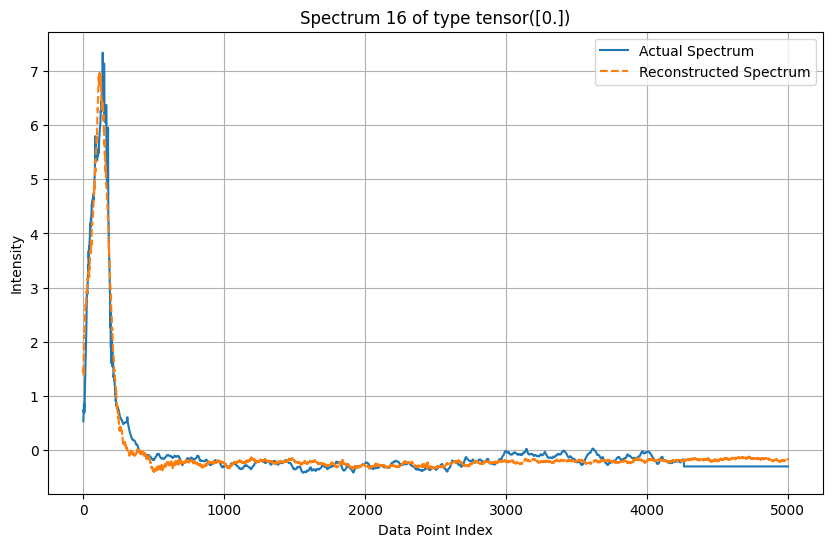

In [251]:
vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) # get 16 random spectra

for X_batch, y_batch in vis_loader:
    # Simulated x-axis values for the spectrum
    x = np.linspace(0, features.shape[1], features.shape[1])
    
    with torch.no_grad():
        preds = AE(X_batch).detach()
    
    for i in range(len(X_batch)):
        plt.figure(figsize=(10, 6))
        plt.plot(x, X_batch[i].numpy(), label='Actual Spectrum')  # Converting tensor to numpy array for plotting
        plt.plot(x, preds[i].numpy(), label='Reconstructed Spectrum',linestyle='--')
        plt.title(f'Spectrum {i+1} of type {y_batch[i]}')
        plt.xlabel('Data Point Index')
        plt.ylabel('Intensity')
        plt.legend()
        plt.grid(True)
    break # just need one batch of 16

In [252]:
preds2 = []
for x in normalized_features:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        preds2.append(AE.encoder(x_tensor).detach())

preds2 = torch.cat(preds2)
preds2

tensor([[157.2860,  33.3537,  -5.3774],
        [145.8185,  22.2821,  24.0033],
        [148.4089,  56.3023, -10.4139],
        ...,
        [137.1256, -21.8652,  66.4697],
        [153.9733,  66.9694, -38.2155],
        [149.4547, -25.0090,  52.9236]])

In [253]:
mask = ~torch.isnan(preds2).any(dim=1)
preds2 = preds2[mask]

In [254]:
encoded2 = preds2
kmeans2 = KMeans(n_clusters=2, random_state=205).fit(encoded2)
kmeans2

KMeans(n_clusters=2, random_state=205)

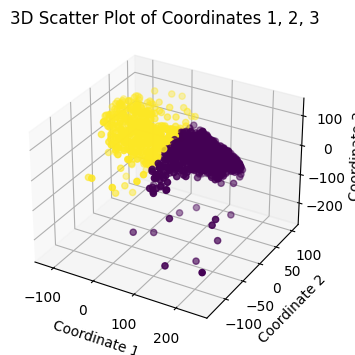

In [255]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans2.labels_, cmap='viridis')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

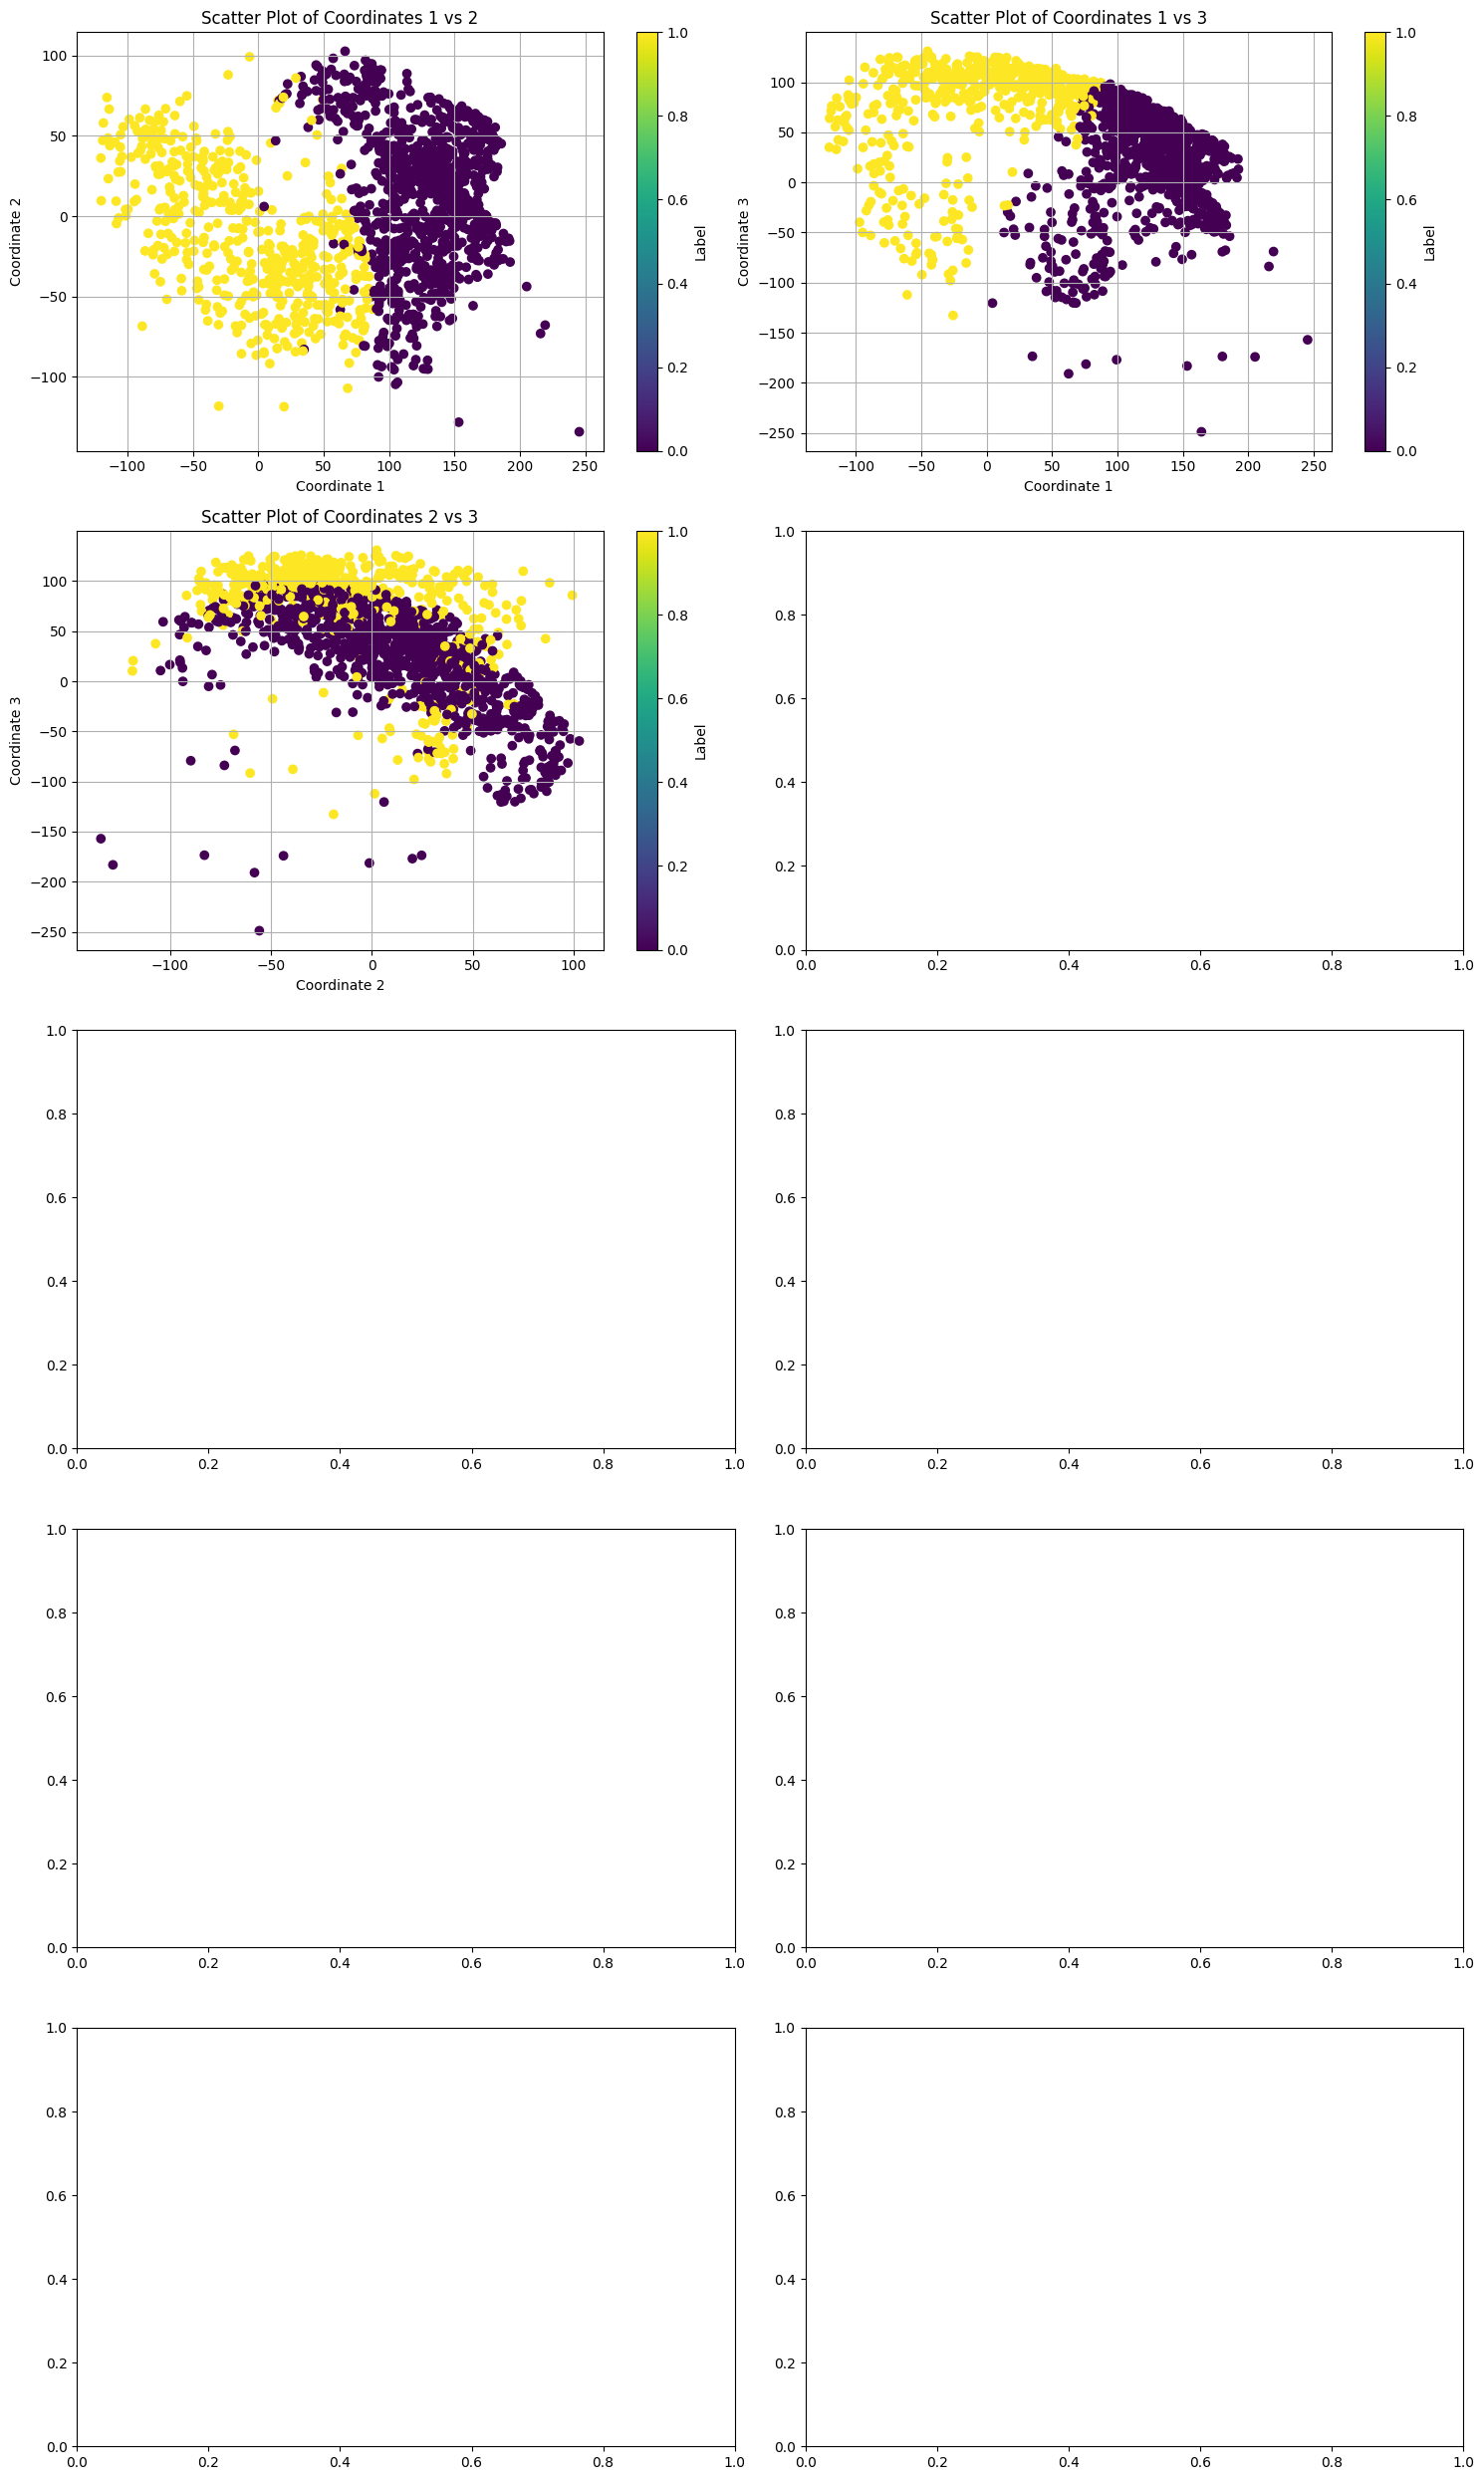

In [256]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(itertools.combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=kmeans2.labels_, cmap='viridis')
    ax.set_title(f'Scatter Plot of Coordinates {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Coordinate {idx1+1}')
    ax.set_ylabel(f'Coordinate {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [257]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_loaded['names'], data_loaded['data']

In [258]:
names_64ms = names_64ms[mask]

Finding Durations: 100%|█████████████████████| 993/993 [00:11<00:00, 90.21GRB/s]


Text(0, 0.5, 'Number of GRBs')

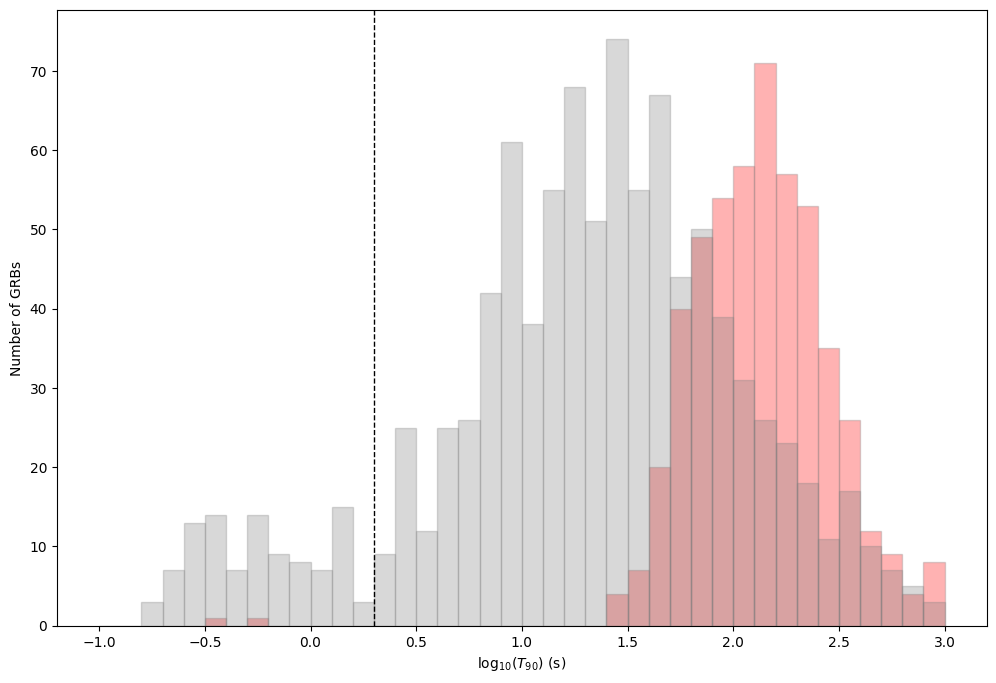

In [259]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = kmeans2.labels_==1
match2 = kmeans2.labels_==0
names1 = names_64ms[match]
names2 = names_64ms[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=['r', 'gray'], ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

In [260]:
fname = f'autoencoded_nr_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.pt'
torch.save(preds2, fname)

In [261]:
durations[mask].shape

(1502,)

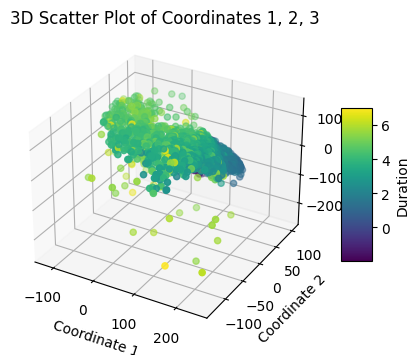

In [262]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations[mask]), cmap='viridis')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


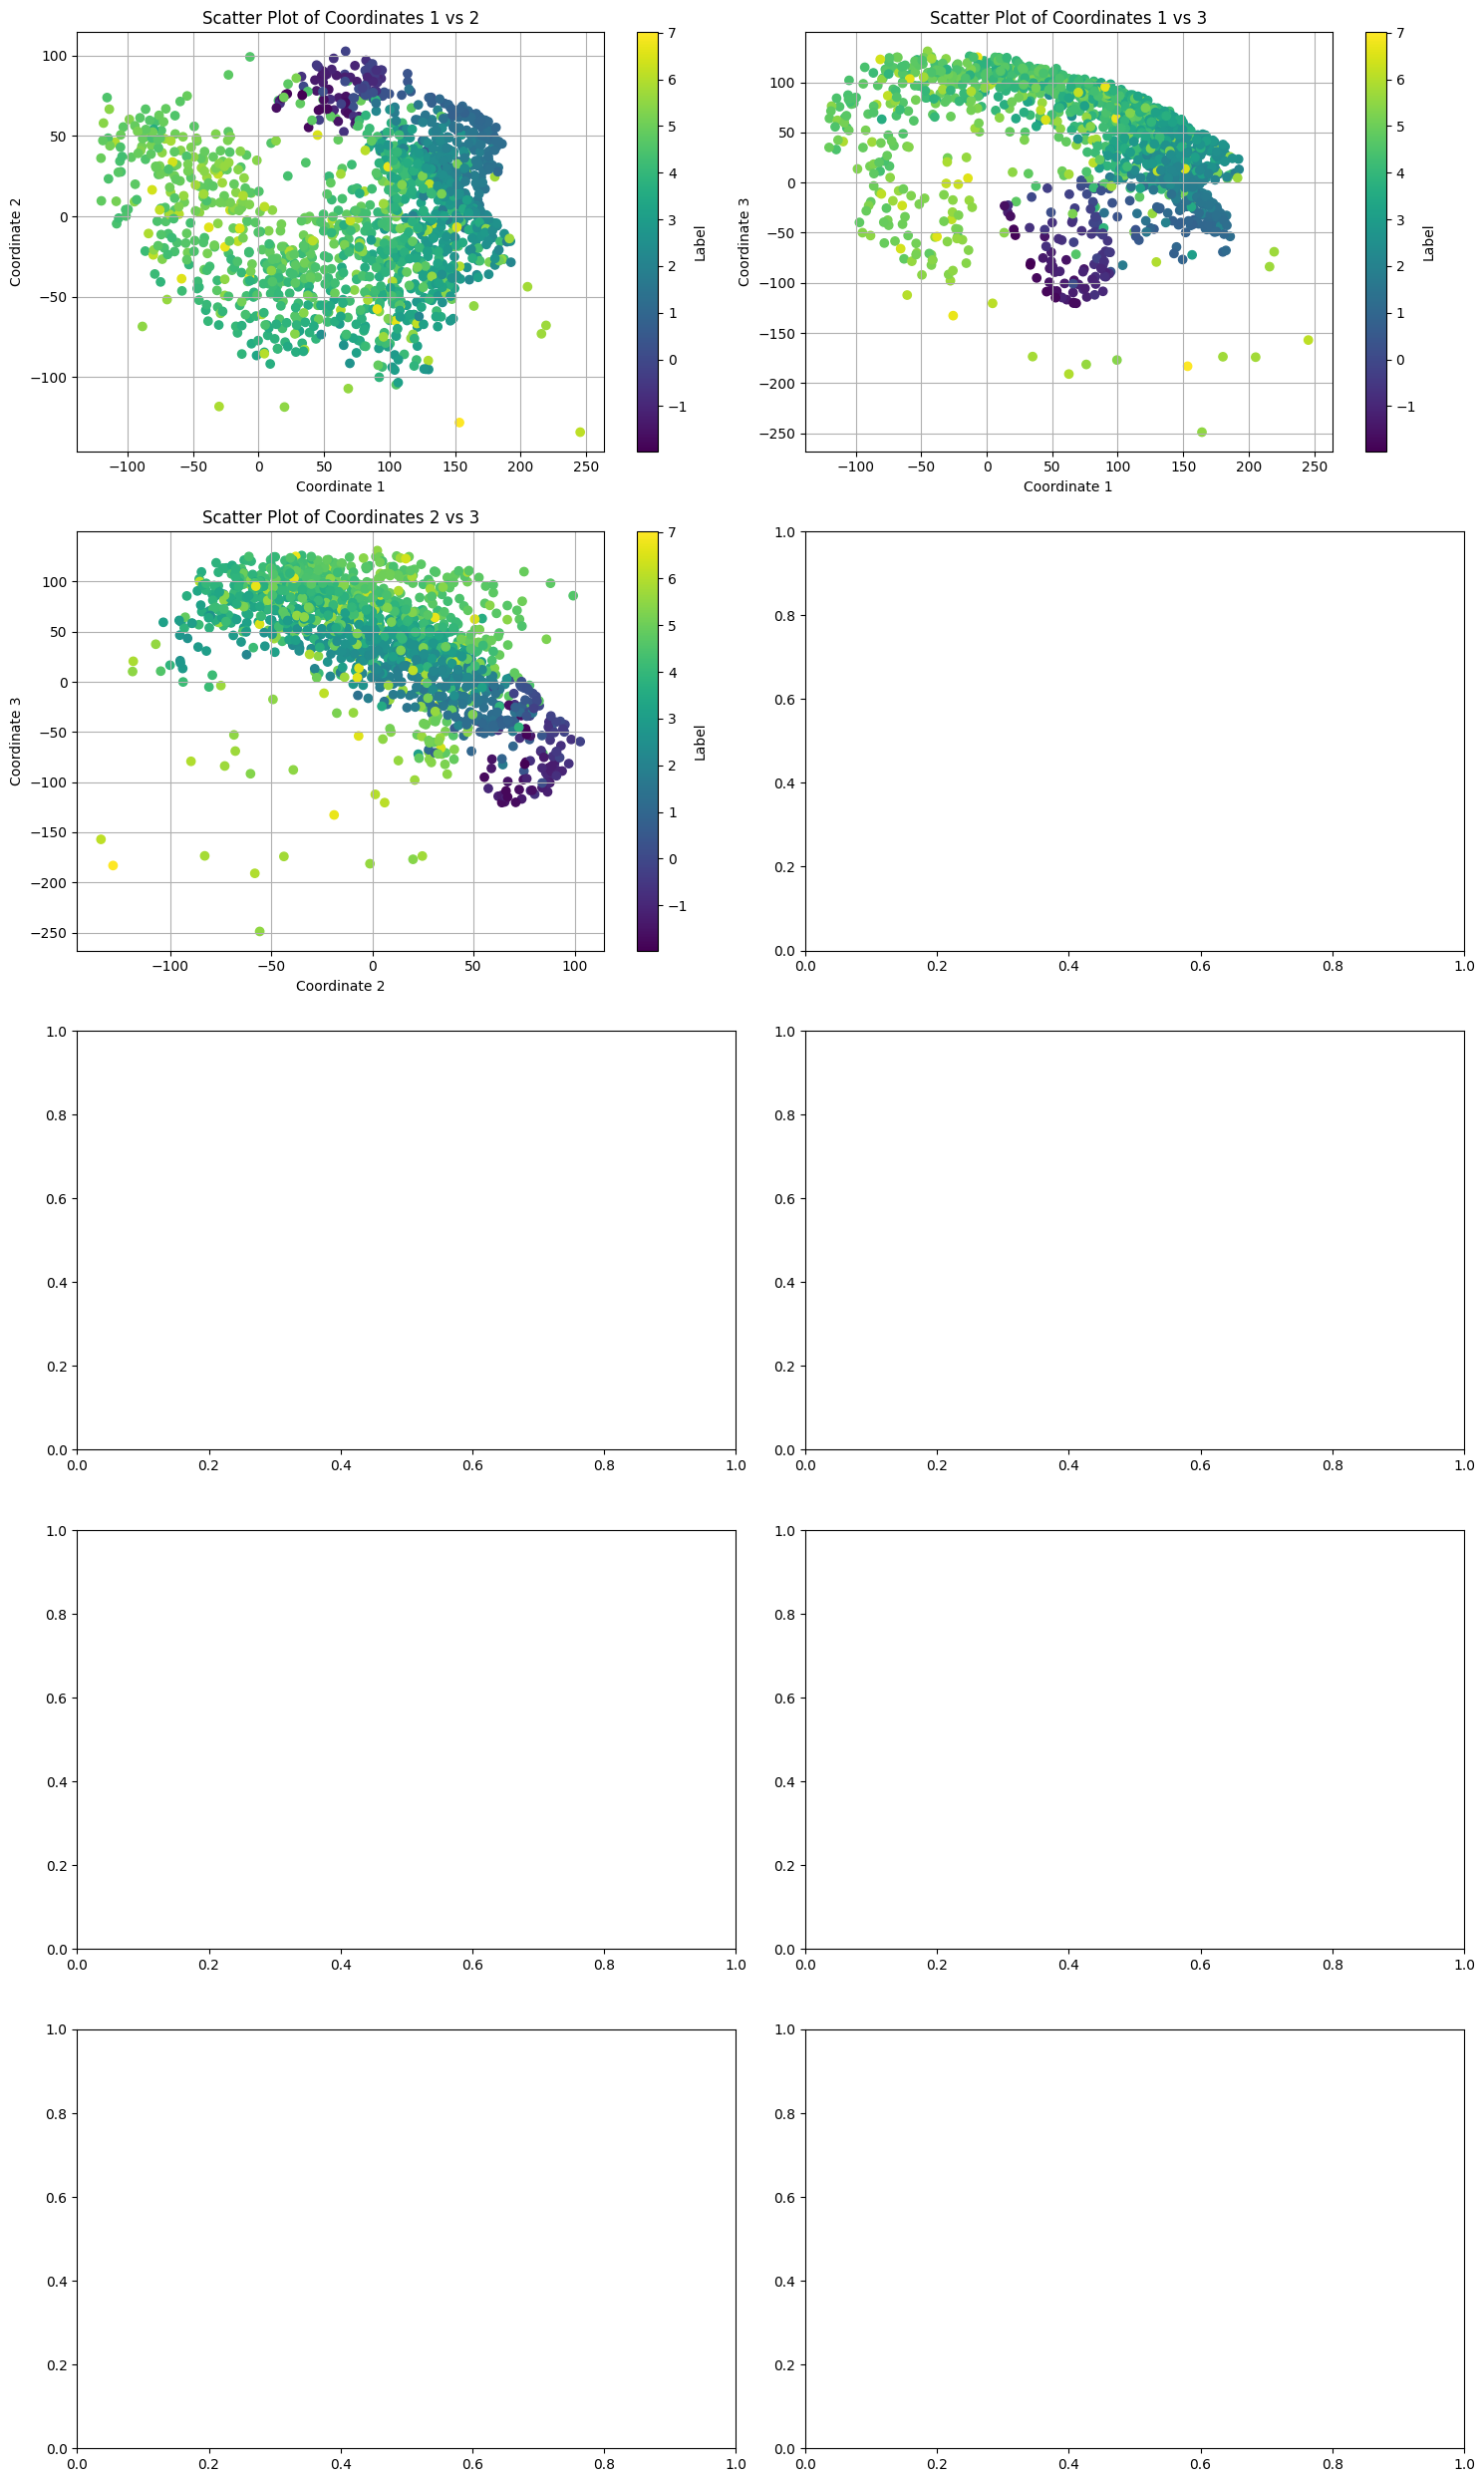

In [263]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(itertools.combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=np.log(durations[mask]), cmap='viridis')
    ax.set_title(f'Scatter Plot of Coordinates {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Coordinate {idx1+1}')
    ax.set_ylabel(f'Coordinate {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [264]:
import numpy as np


# Exploring the array
print("Shape of the array:", durations[mask].shape)
print("Data type of the array:", durations[mask].dtype)
print("Number of dimensions:", durations[mask].ndim)
print("Total number of elements:", durations[mask].size)

# Describing the durations[mask]
print("Mean of the array:", np.mean(durations[mask]))
print("Standard deviation:", np.std(durations[mask]))
print("Minimum value:", np.min(durations[mask]))
print("Maximum value:", np.max(durations[mask]))
print("25th percentile:", np.percentile(durations[mask], 25))
print("Median:", np.median(durations[mask]))
print("75th percentile:", np.percentile(durations[mask], 75))
print("90th percentile:", np.percentile(durations[mask], 90))
print("95th percentile:", np.percentile(durations[mask], 95))
print("99th percentile:", np.percentile(durations[mask], 99))

Shape of the array: (1502,)
Data type of the array: float64
Number of dimensions: 1
Total number of elements: 1502
Mean of the array: 76.43213315579227
Standard deviation: 107.92946152195434
Minimum value: 0.14
Maximum value: 1104.7520000000002
25th percentile: 11.835
Median: 41.013999999999996
75th percentile: 98.201
90th percentile: 182.63600000000005
95th percentile: 270.83860000000004
99th percentile: 548.7248400000002


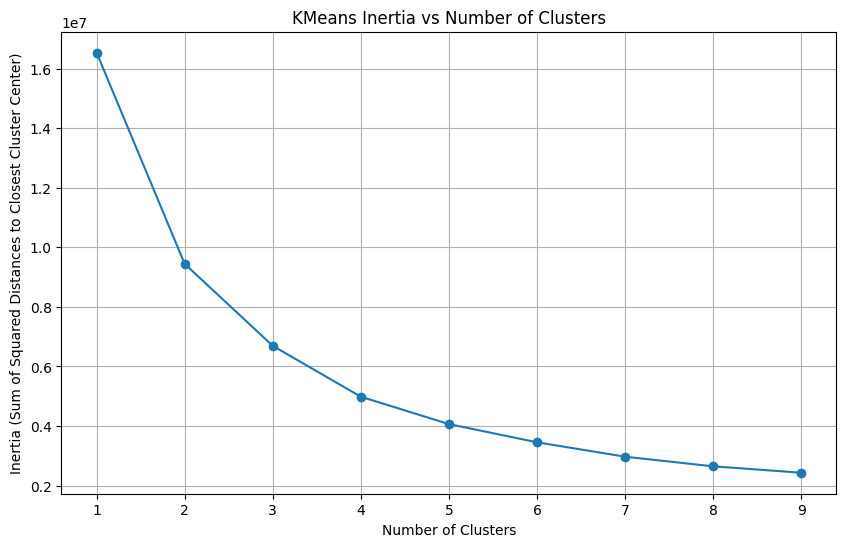

In [265]:
# Try different numbers of clusters
num_clusters = range(1, 10)  # You can adjust the range as needed
inertias = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=205)
    kmeans.fit(encoded2)
    inertias.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, inertias, marker='o')
plt.title('KMeans Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances to Closest Cluster Center)')
plt.grid(True)
plt.show()

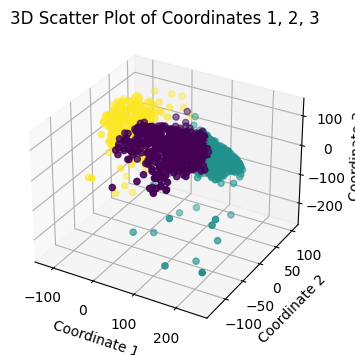

In [266]:
kmeans3 = KMeans(n_clusters=3, random_state=205).fit(encoded2)

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans3.labels_, cmap='viridis')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

Finding Durations: 100%|█████████████████████| 287/287 [00:08<00:00, 32.80GRB/s]


Text(0, 0.5, 'Number of GRBs')

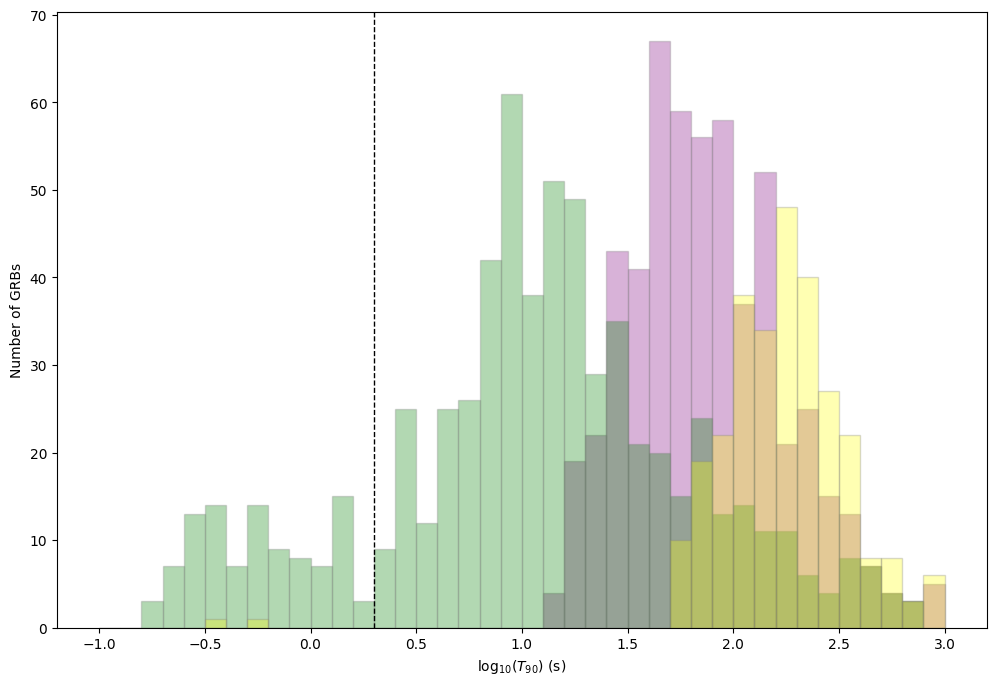

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match1 = kmeans3.labels_==0
match2 = kmeans3.labels_==1
match3 = kmeans3.labels_==2
names1 = names_64ms[match1]
names2 = names_64ms[match2]
names3 = names_64ms[match3]
swift.duration_histogram(names=[names1, names2, names3], alpha=0.3, color_groups=['purple', 'green', 'yellow'], ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

In [268]:
torch.sum(~mask)

tensor(0)

In [269]:
compact_mergers = [
    "GRB130603B",
    "GRB060614",
    "GRB080503",
    "GRB050709",
    "GRB050724",
    "GRB061006",
    "GRB070714B",
    "GRB160821B",
    "GRB111005A",
    "GRB150101B",
    "GRB070809",
    "GRB211211A",
    "GRB211227A",
    "GRB191019A",
    "GRB230307A"
]

In [270]:
indices = np.where(np.isin(grb_names, compact_mergers))[0]
indices

array([  47,  140,  169,  226,  235,  291,  581,  732, 1016, 1259, 1417,
       1421])

In [271]:
# Initialize a dictionary to store the results with the merger names as keys
results = {merger: None for merger in compact_mergers}  # Start with None or any placeholder for not found

# Find indices for each item in compact_mergers within names_64ms
for merger in compact_mergers:
    indices = np.where(names_64ms == merger)[0]
    results[merger] = indices[0] if indices.size > 0 else -1  # Store index if found, else store -1

# Printing the results
for key, value in results.items():
    print(f"{key}: {kmeans2.labels_[value]}")

GRB130603B: 0
GRB060614: 1
GRB080503: 1
GRB050709: 0
GRB050724: 0
GRB061006: 0
GRB070714B: 0
GRB160821B: 0
GRB111005A: 0
GRB150101B: 0
GRB070809: 0
GRB211211A: 0
GRB211227A: 1
GRB191019A: 1
GRB230307A: 0
